### Evaluación formal de modelos de ML

En este notebook presentamos los resultados de una metodología formal elegida a partir de los resultados observados en el Nb.2. Evaluaremos los modelos sobre los cuales observamos las mejores métricas de desempeño en el ejercicio anterior. Elegiremos una ventana de rezagos de uno a quince y observaremos los resultados de evaluar estos modelos para cada uno de los rezagos. Del mismo modo, observaremos la capacidad predictiva de los modelos hacia adelante, es decir; evaluaremos si a partir de las observaciones actuales es posible tener una buena predicción de las condiciones de arbitraje futuras. Compararemos ambos enfoques y elegiremos un modelo y su ventana de lags óptima con el propósito de realizar una evaluación financiera del desempeño del modelo. Para esto, definiremos, en términos de la función de arbitraje, una función de backtestig sobre las predicciones y calcularemos el estado de pérdidas y ganacias para las predicciones.

### Definiciones

In [2]:
#Imports
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import xgboost as xgb
from xgboost import XGBClassifier 
from sklearn.model_selection import cross_val_score, RepeatedKFold,RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
import matplotlib.pyplot as plt # Matplotlib
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import operator
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearnex import patch_sklearn
from sklearn.ensemble import HistGradientBoostingClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier
import sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import cross_validate, StratifiedKFold, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
#Importamos el VotingClssifier de sklearn para observar si los resultados mejoran
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline


patch_sklearn()
#from Funciones import *

%matplotlib inline


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
# Funcion para calcular y visualizar la matriz de confusion 
def plotCM(ytrue, ypred, clases=None, normalize = False, ax = None):
    """ Funcion para calcular y visualizar la matriz de confusion"""
    
    if clases == None:
        clases = list(set(ytrue))
        clases.sort() # etiquetas unicas ordenadas alfabeticamente
    
    CM = confusion_matrix(ytrue,ypred, labels=clases)
    
    #Normaliza la matriz de confusion dividiendo cada fila por el total de verdaderos
    if normalize:
        CM = 100*CM / CM.sum(axis=1).reshape(-1,1) #Aprovechando el Broadcasting!
 
    df = pd.DataFrame(CM, index=clases, columns=clases)
    df.index.name = 'True'; df.columns.name = 'Predicted'
    
    sns.heatmap( df, # Visualizando la matriz de confusion
             annot=True, fmt='2.1f', cmap='ocean_r',cbar=False,square=True, annot_kws={'fontsize':10}, ax=ax )
    
    plt.show()

In [4]:
class MajorityVoteClassifier(BaseEstimator, 
                             ClassifierMixin):
    """ A majority vote ensemble classifier

    Parameters
    ----------
    classifiers : array-like, shape = [n_classifiers]
      Different classifiers for the ensemble

    vote : str, {'classlabel', 'probability'} (default='classlabel')
      If 'classlabel' the prediction is based on the argmax of
        class labels. Else if 'probability', the argmax of
        the sum of probabilities is used to predict the class label
        (recommended for calibrated classifiers).

    weights : array-like, shape = [n_classifiers], optional (default=None)
      If a list of `int` or `float` values are provided, the classifiers
      are weighted by importance; Uses uniform weights if `weights=None`.

    """
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """ Fit classifiers.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Matrix of training examples.

        y : array-like, shape = [n_examples]
            Vector of target class labels.

        Returns
        -------
        self : object

        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError(f"vote must be 'probability' or 'classlabel'"
                             f"; got (vote={self.vote})")

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError(f'Number of classifiers and weights must be equal'
                             f'; got {len(self.weights)} weights,'
                             f' {len(self.classifiers)} classifiers')

        # Use LabelEncoder to ensure class labels start with 0, which
        # is important for np.argmax call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """ Predict class labels for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Matrix of training examples.

        Returns
        ----------
        maj_vote : array-like, shape = [n_examples]
            Predicted class labels.
            
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote

            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """ Predict class probabilities for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Training vectors, where n_examples is the number of examples and
            n_features is the number of features.

        Returns
        ----------
        avg_proba : array-like, shape = [n_examples, n_classes]
            Weighted average probability for each class per example.

        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """ Get classifier parameter names for GridSearch"""
        if not deep:
            return super().get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep=True).items():
                    out[f'{name}__{key}'] = value
            return out

### Bases de datos

In [5]:
base=pd.read_excel("arb.xlsx")

In [6]:
base.head()

,Unnamed: 0,Date,Hora_COL,Minuto,Hora_NY,Festivo_COL,Festivo_NYSE,Next_Day,Subasta,PFB_ABIERTO,...,USD_BID,USD_ASK,ASK_CIB,BID_CIB,ASK_PFB,BID_PFB,Spread_BE_SL,Spread_BL_SE,Arbitraje_BE_SL,Arbitraje_BL_SE
0,0,2022-01-03,9,54,9,False,False,0,0,1,...,4073.00,4076.9,31.74,31.55,32300,32010,-352.32380,-186.30125,0,0
1,1,2022-01-03,9,55,9,False,False,0,0,1,...,4072.72,4076.0,31.75,31.58,32300,32290,-75.37175,-157.96754,0,0
2,2,2022-01-03,9,56,9,False,False,0,0,1,...,4072.72,4076.0,31.76,31.60,32300,32290,-85.56300,-137.60644,0,0
3,3,2022-01-03,9,57,9,False,False,0,0,1,...,4072.72,4075.0,31.76,31.60,32300,32290,-77.62100,-137.60644,0,0
4,4,2022-01-03,9,58,9,False,False,0,0,1,...,4072.00,4075.0,31.76,31.62,32300,32290,-77.62100,-122.93550,0,0


In [7]:
#Definimos las columnas de precio
columnas_precio=['CIB_close', 'COP_close', 'PFB_close', 'SPX_close', 'tasa_cambio',
       'USD_BID', 'USD_ASK', 'ASK_CIB', 'BID_CIB', 'ASK_PFB', 'BID_PFB',
       'Spread_BE_SL', 'Spread_BL_SE']

### Funciones para crear lags en los precios

In [8]:
def add_lags(data, ric, lags):
    cols = []
    df = pd.DataFrame(data[ric])
    for lag in range(1, lags + 1):
        col = 'lag_{}'.format(lag)+'_'+str(ric)  # defines the column name
        df[col] = df[ric].shift(lag)  # creates the lagged data column
        cols.append(col)  # stores the column name
    df.dropna(inplace=True)  # gets rid of incomplete data rows
    return df, cols

In [9]:
def base_lags(base_all,lags):
    base_lags=add_lags(base_all,columnas_precio[0],lags)[0].iloc[:,1:]
    for column in columnas_precio[1:]:
        bse=add_lags(base_all,column,lags)[0].iloc[:,1:]
        base_lags=pd.concat([base_lags,bse],axis=1,join='outer')
        
    return pd.concat([base.iloc[lags:,:],base_lags],axis=1,join='outer')

In [10]:
#Definimos un rango de lags
lags=range(1,16)

### Clasificadores

Definimos un grupo de clasificadores. Esta vez partiremos de un clasificador base Random Forest. Tomamos además, los clasificadores con mejor desempeño en la evaluación por tanteo: una instancia de Gradient Boosting, una instancia de un clasificador LigthGBM y un clasifidor Histogram Gradient Boosting.

In [11]:
clf1 = RandomForestClassifier(max_depth=100, random_state=0)
clf2 = xgb.XGBClassifier(n_estimators=100, learning_rate=0.01, max_depth=4, random_state=1, use_label_encoder=False)
clf3 = lgb.LGBMClassifier(num_leaves=31,
                        learning_rate=0.5,
                        n_estimators=20)

clf4=HistGradientBoostingClassifier()


Teniendo en cuenta que el desempeño observado al agregar las variables categóricas a los features no produjo un resultado sustancialmente superior en la evaluación al tanteo, la estimación actual se realizará filtrando este tipo de variables. El efecto de las variables categóricas lo observaremos más adelante en la implementación del modelo de Deep Learning.

In [12]:
columnas_fecha=['Date', 'Hora_COL', 'Minuto', 'Hora_NY', 'Festivo_COL', 'Festivo_NYSE', 'Next_Day', 'Subasta','PFB_ABIERTO',
'CIB_ABIERTO']
columnas_arb=['Arbitraje_BE_SL','Arbitraje_BL_SE']
sobrantes=columnas_fecha+columnas_precio+columnas_arb

### Evaluación para un rango de lags

Para el rango de lags de uno a quince, evaluaremos cada uno de los modelos previamente definidos. La función de evaluación, toma los rezagos en los precios de las variables para cada variable de precio y realiza una clasificación multiclase para las condiciones de arbitraje actuales. Para lograr una evaluación más precisa de las métricas de desempeño, utilizaremos un cross validation estratificado repetido. En cada repetición se realizan 3 splits para el conjunto de entrenamiento. Se realizan cinco repeticiones y se tabulan los resultados promedio para el accuracy, la precisión y el recall promedio, con sus respectivas desviaciones estándar. Se produce una matriz de confusión para cada lag y se grafican los resultados para las métricas de desempeño.

In [13]:
def evaluar_modelo(clf):
    modelo=clf
    resultados=pd.DataFrame(columns=['Modelo','#lags','repeticiones','fit_time', 'score_time',
                                     'test_accuracy', 'test_accuracy_desvest', 'train_accuracy','test_precision_macro', 'test_precision_macro_desvest',
                                     'train_precision_macro','test_recall_macro', 'train_recall_macro'])
    
    for lag in lags:
        lags_lag=base_lags(base,lag)
        columnas_fecha=['Date', 'Hora_COL', 'Minuto', 'Hora_NY', 'Festivo_COL', 'Festivo_NYSE', 'Next_Day', 'Subasta','PFB_ABIERTO','CIB_ABIERTO']
        columnas_arb=['Arbitraje_BE_SL','Arbitraje_BL_SE']
        cols_sobrantes=columnas_fecha+columnas_precio+columnas_arb
        X=lags_lag.drop(sobrantes, axis=1)
        X_std=StandardScaler().fit_transform(X)
        y_BL_SE=lags_lag['Arbitraje_BL_SE']
        y_BE_SL=lags_lag['Arbitraje_BE_SL']
        y_cat=[]
        for i in range(len(X)):
            if y_BE_SL.loc[i+lag]==1: 
                y_cat.append(1)
            elif y_BL_SE.loc[i+lag]==1:
                y_cat.append(2)
            else:
                y_cat.append(0)

        folds=range(0,1)
        accuracy_scores=[]
        precision_scores=[]
        recall_scores=[]

        for fold in folds:

            X_train, X_test, y_train, y_test = train_test_split(X_std, y_cat, test_size=0.3, random_state=None, stratify=y_cat,shuffle=True)

            #gbm=modelo.fit(X_train,y_train)
            cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=123)
            cv_scores = cross_validate(
                    estimator = modelo,
                    X         = X_train,
                    y         = y_train,
                    scoring   =('accuracy','precision_macro', 'recall_macro', 'f1_macro'),
                    cv        = cv,
                    return_train_score = True
                )
            
            cv_scores = pd.DataFrame(cv_scores)

            resultados=resultados.append({'Modelo': modelo,'#lags': lag,'repeticiones': len(cv_scores),
                                          'fit_time': cv_scores['fit_time'].mean(),'score_time': cv_scores['score_time'].mean(),
                                          'test_accuracy': cv_scores['test_accuracy'].mean(),
                                          'test_accuracy_desvest': cv_scores['test_accuracy'].std(), 
                                          'train_accuracy': cv_scores['train_accuracy'].mean(),
                                          'test_precision_macro': cv_scores['test_precision_macro'].mean(),
                                          'test_precision_macro_desvest': cv_scores['test_precision_macro'].std(),
                                          'train_precision_macro': cv_scores['train_precision_macro'].mean(),
                                          'test_recall_macro': cv_scores['test_recall_macro'].mean(),
                                          'test_recall_macro_desvest': cv_scores['test_recall_macro'].std(),
                                          'train_recall_macro': cv_scores['train_recall_macro'].mean(),
                                          'train_recall_macro_desvest': cv_scores['train_recall_macro'].std()}, ignore_index=True)
           
            #Realizamos prueba con el conjunto de test, e imprimimos la matriz de confusión para las predicciones
            y_pred = cross_val_predict(modelo, X_test,y_test,cv=StratifiedKFold(n_splits=3, shuffle=True))
            print(f'Modelo: {clf}')
            print(f'cross_val results para el conjunto de test para #lags: {lag}')
            plotCM(y_test,y_pred, normalize=True)
    t=np.arange(len(lags))
    ci_acc=1.96* 100*resultados['test_accuracy_desvest'] / len(lags)
    ci_prec=1.96* 100*resultados['test_precision_macro_desvest'] / len(lags)
    ci_recall=1.96* 100*resultados['test_precision_macro_desvest'] / len(lags)
    
    fig, axes = plt.subplots(3, 1)

    axes[0].plot(t,100*resultados['test_accuracy'] , color = 'xkcd:cherry' , marker = 'o')
    axes[0].fill_between(t,(100*resultados['test_accuracy']-ci_acc), (100*resultados['test_accuracy']+ci_acc), color='xkcd:cherry', alpha=0.1)
    axes[0].set_xlabel('lags')
    axes[0].set_ylabel('Accuracy (%)')
    axes[0].set_facecolor((1,1,1))
    axes[0].spines['left'].set_color('black')
    axes[0].spines['right'].set_color('black')
    axes[0].spines['top'].set_color('black')
    axes[0].spines['bottom'].set_color('black')
    axes[0].spines['left'].set_linewidth(0.5)
    axes[0].spines['right'].set_linewidth(0.5)
    axes[0].spines['top'].set_linewidth(0.5)
    axes[0].spines['bottom'].set_linewidth(0.5)
    axes[0].grid(linestyle='--', linewidth='0.5', color='grey', alpha=0.5)

    axes[1].plot(t,100*resultados['test_precision_macro'] , color = 'xkcd:royal blue' , marker = 'o')
    axes[1].fill_between(t,(100*resultados['test_precision_macro']-ci_prec), (100*resultados['test_precision_macro']+ci_prec), color='xkcd:royal blue', alpha=0.1)
    axes[1].set_xlabel('lags')
    axes[1].set_ylabel('Precision(%)')
    axes[1].set_facecolor((1,1,1))
    axes[1].spines['left'].set_color('black')
    axes[1].spines['right'].set_color('black')
    axes[1].spines['top'].set_color('black')
    axes[1].spines['bottom'].set_color('black')
    axes[1].spines['left'].set_linewidth(0.5)
    axes[1].spines['right'].set_linewidth(0.5)
    axes[1].spines['top'].set_linewidth(0.5)
    axes[1].spines['bottom'].set_linewidth(0.5)
    axes[1].grid(linestyle='--', linewidth='0.5', color='grey', alpha=0.5)

    axes[2].plot(t,100*resultados['test_recall_macro'] , color = 'xkcd:emerald' , marker = 'o')
    axes[2].fill_between(t,(100*resultados['test_recall_macro']-ci_recall), (100*resultados['test_recall_macro']+ci_recall), color='xkcd:emerald', alpha=0.1)
    axes[2].set_xlabel('lags')
    axes[2].set_ylabel('Recall (%)')
    axes[2].set_facecolor((1,1,1))
    axes[2].spines['left'].set_color('black')
    axes[2].spines['right'].set_color('black')
    axes[2].spines['top'].set_color('black')
    axes[2].spines['bottom'].set_color('black')
    axes[2].spines['left'].set_linewidth(0.5)
    axes[2].spines['right'].set_linewidth(0.5)
    axes[2].spines['top'].set_linewidth(0.5)
    axes[2].spines['bottom'].set_linewidth(0.5)
    axes[2].grid(linestyle='--', linewidth='0.5', color='grey', alpha=0.5)
    
    plt.grid(True)
    plt.tight_layout()
    name=str(clf)
    resultados.to_excel(name[0:7]+'.xlsx')
    return resultados




### Resultados Random Forest

Modelo: RandomForestClassifier(max_depth=100, random_state=0)
cross_val results para el conjunto de test para #lags: 1


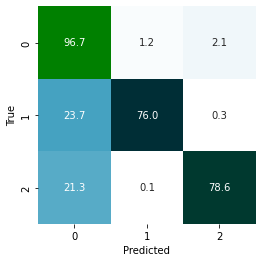

Modelo: RandomForestClassifier(max_depth=100, random_state=0)
cross_val results para el conjunto de test para #lags: 2


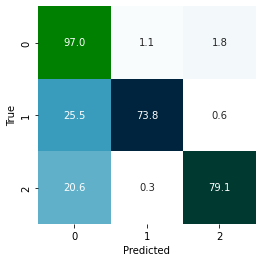

Modelo: RandomForestClassifier(max_depth=100, random_state=0)
cross_val results para el conjunto de test para #lags: 3


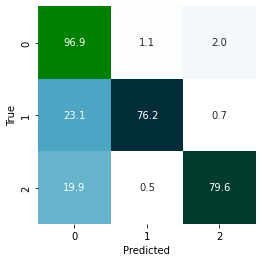

Modelo: RandomForestClassifier(max_depth=100, random_state=0)
cross_val results para el conjunto de test para #lags: 4


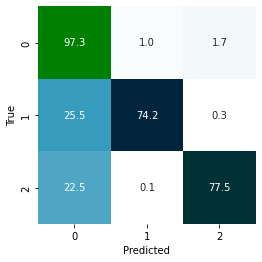

Modelo: RandomForestClassifier(max_depth=100, random_state=0)
cross_val results para el conjunto de test para #lags: 5


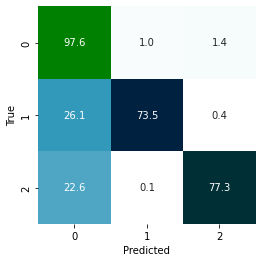

Modelo: RandomForestClassifier(max_depth=100, random_state=0)
cross_val results para el conjunto de test para #lags: 6


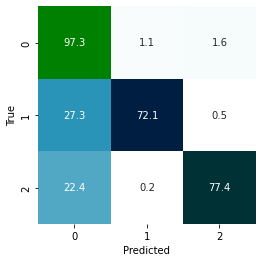

Modelo: RandomForestClassifier(max_depth=100, random_state=0)
cross_val results para el conjunto de test para #lags: 7


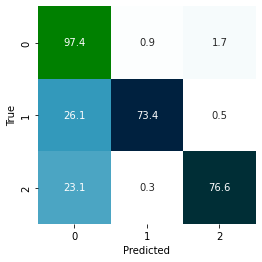

Modelo: RandomForestClassifier(max_depth=100, random_state=0)
cross_val results para el conjunto de test para #lags: 8


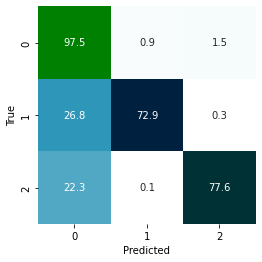

Modelo: RandomForestClassifier(max_depth=100, random_state=0)
cross_val results para el conjunto de test para #lags: 9


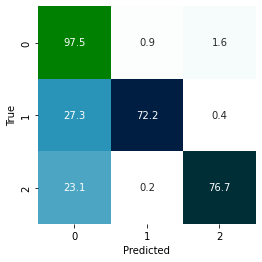

Modelo: RandomForestClassifier(max_depth=100, random_state=0)
cross_val results para el conjunto de test para #lags: 10


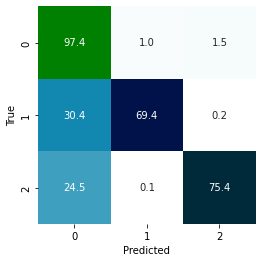

Modelo: RandomForestClassifier(max_depth=100, random_state=0)
cross_val results para el conjunto de test para #lags: 11


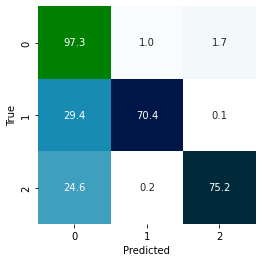

Modelo: RandomForestClassifier(max_depth=100, random_state=0)
cross_val results para el conjunto de test para #lags: 12


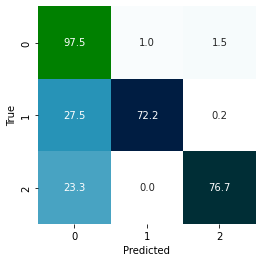

Modelo: RandomForestClassifier(max_depth=100, random_state=0)
cross_val results para el conjunto de test para #lags: 13


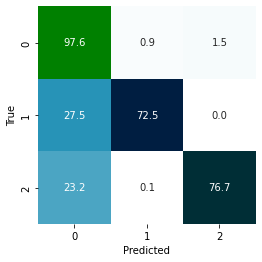

Modelo: RandomForestClassifier(max_depth=100, random_state=0)
cross_val results para el conjunto de test para #lags: 14


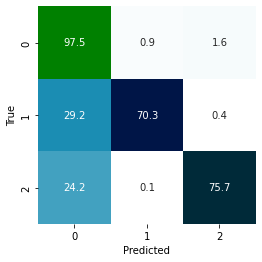

Modelo: RandomForestClassifier(max_depth=100, random_state=0)
cross_val results para el conjunto de test para #lags: 15


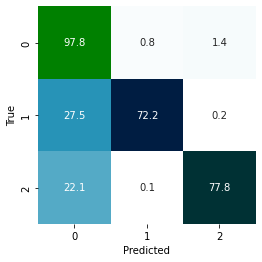

,Modelo,#lags,repeticiones,fit_time,score_time,test_accuracy,test_accuracy_desvest,train_accuracy,test_precision_macro,test_precision_macro_desvest,train_precision_macro,test_recall_macro,train_recall_macro,test_recall_macro_desvest,train_recall_macro_desvest
0,"RandomForestClassifier(max_depth=100, random_s...",1,15,0.884372,0.139634,0.933503,0.001960,0.996126,0.876983,0.005784,0.994189,0.846189,0.988986,0.006261,0.002229
1,"RandomForestClassifier(max_depth=100, random_s...",2,15,1.235502,0.150736,0.933473,0.001851,0.997177,0.882328,0.004810,0.996826,0.841353,0.992564,0.007431,0.001857
2,"RandomForestClassifier(max_depth=100, random_s...",3,15,1.635166,0.167420,0.934357,0.001285,0.997968,0.886954,0.003919,0.997219,0.836412,0.994992,0.005004,0.001679
3,"RandomForestClassifier(max_depth=100, random_s...",4,15,2.071993,0.216421,0.935829,0.001579,0.997928,0.889997,0.004037,0.997801,0.840332,0.994803,0.004856,0.001617
4,"RandomForestClassifier(max_depth=100, random_s...",5,15,2.419130,0.232644,0.935754,0.002014,0.998248,0.890278,0.004906,0.996921,0.839358,0.996769,0.006445,0.001318
5,"RandomForestClassifier(max_depth=100, random_s...",6,15,3.056365,0.263292,0.938061,0.001334,0.998671,0.899990,0.003562,0.998143,0.838753,0.996843,0.005132,0.001098
6,"RandomForestClassifier(max_depth=100, random_s...",7,15,2.616308,0.231182,0.937084,0.002523,0.998282,0.897326,0.005258,0.998212,0.837253,0.995856,0.007011,0.001308
7,"RandomForestClassifier(max_depth=100, random_s...",8,15,3.154105,0.259836,0.936164,0.002294,0.998152,0.896035,0.004738,0.997483,0.835062,0.996212,0.006907,0.001239
8,"RandomForestClassifier(max_depth=100, random_s...",9,15,3.326378,0.250594,0.937172,0.002023,0.998359,0.901260,0.006568,0.998142,0.834256,0.996237,0.005948,0.002467
9,"RandomForestClassifier(max_depth=100, random_s...",10,15,3.896054,0.284104,0.937376,0.001808,0.998126,0.902350,0.007297,0.998204,0.835558,0.995605,0.007757,0.001787


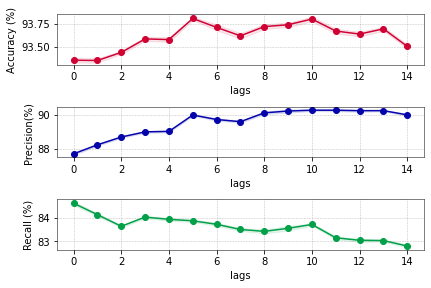

In [14]:
evaluar_modelo(clf1)

Modelo: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=1,
              reg_alpha=None, reg_lambda=None, ...)
cross_val results para el conjunto de test para #lags: 1


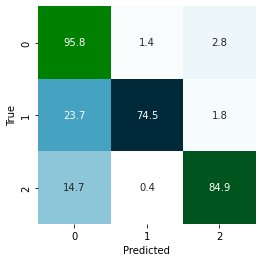

Modelo: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=1,
              reg_alpha=None, reg_lambda=None, ...)
cross_val results para el conjunto de test para #lags: 2


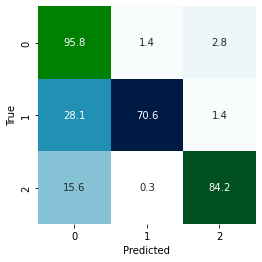

Modelo: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=1,
              reg_alpha=None, reg_lambda=None, ...)
cross_val results para el conjunto de test para #lags: 3


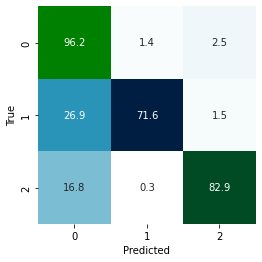

Modelo: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=1,
              reg_alpha=None, reg_lambda=None, ...)
cross_val results para el conjunto de test para #lags: 4


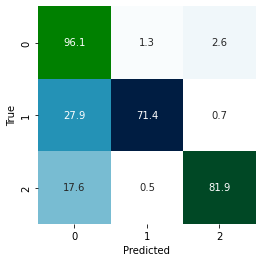

Modelo: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=1,
              reg_alpha=None, reg_lambda=None, ...)
cross_val results para el conjunto de test para #lags: 5


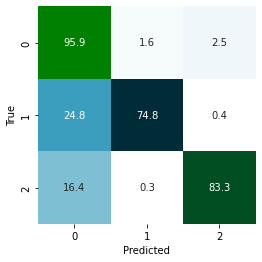

Modelo: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=1,
              reg_alpha=None, reg_lambda=None, ...)
cross_val results para el conjunto de test para #lags: 6


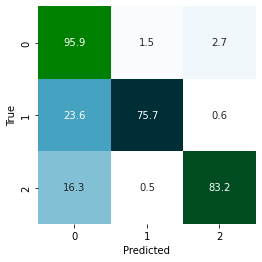

Modelo: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=1,
              reg_alpha=None, reg_lambda=None, ...)
cross_val results para el conjunto de test para #lags: 7


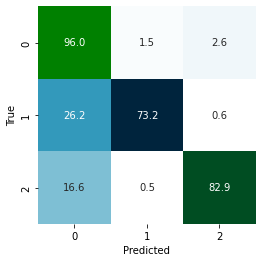

Modelo: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=1,
              reg_alpha=None, reg_lambda=None, ...)
cross_val results para el conjunto de test para #lags: 8


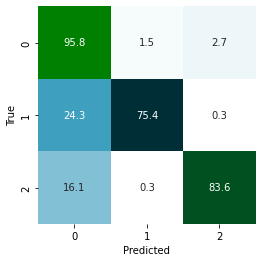

Modelo: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=1,
              reg_alpha=None, reg_lambda=None, ...)
cross_val results para el conjunto de test para #lags: 9


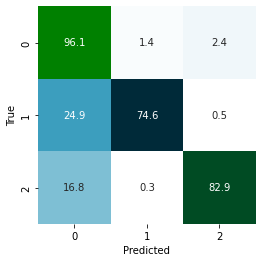

Modelo: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=1,
              reg_alpha=None, reg_lambda=None, ...)
cross_val results para el conjunto de test para #lags: 10


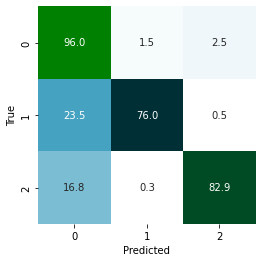

Modelo: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=1,
              reg_alpha=None, reg_lambda=None, ...)
cross_val results para el conjunto de test para #lags: 11


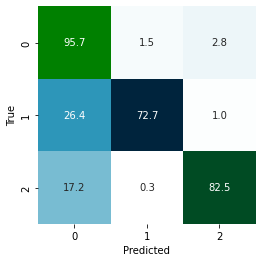

Modelo: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=1,
              reg_alpha=None, reg_lambda=None, ...)
cross_val results para el conjunto de test para #lags: 12


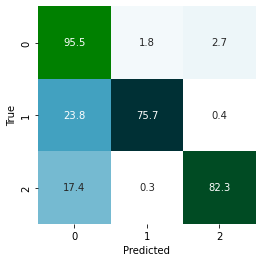

Modelo: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=1,
              reg_alpha=None, reg_lambda=None, ...)
cross_val results para el conjunto de test para #lags: 13


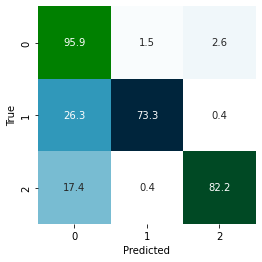

Modelo: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=1,
              reg_alpha=None, reg_lambda=None, ...)
cross_val results para el conjunto de test para #lags: 14


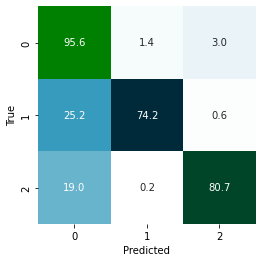

Modelo: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=1,
              reg_alpha=None, reg_lambda=None, ...)
cross_val results para el conjunto de test para #lags: 15


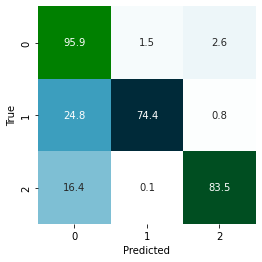

,Modelo,#lags,repeticiones,fit_time,score_time,test_accuracy,test_accuracy_desvest,train_accuracy,test_precision_macro,test_precision_macro_desvest,train_precision_macro,test_recall_macro,train_recall_macro,test_recall_macro_desvest,train_recall_macro_desvest
0,"XGBClassifier(base_score=None, booster=None, c...",1,15,8.520148,0.114494,0.929921,0.002835,0.931253,0.856603,0.006300,0.859688,0.846076,0.849064,0.006001,0.002446
1,"XGBClassifier(base_score=None, booster=None, c...",2,15,13.501232,0.117752,0.930939,0.002019,0.933119,0.862914,0.005646,0.868130,0.844206,0.849746,0.005000,0.004251
2,"XGBClassifier(base_score=None, booster=None, c...",3,15,13.813562,0.107180,0.929828,0.002231,0.932490,0.859553,0.007298,0.865777,0.844837,0.850701,0.003808,0.003216
3,"XGBClassifier(base_score=None, booster=None, c...",4,15,17.549441,0.112566,0.929554,0.002083,0.932054,0.855632,0.005040,0.861517,0.845327,0.850917,0.007189,0.002979
4,"XGBClassifier(base_score=None, booster=None, c...",5,15,21.221516,0.114029,0.930476,0.001670,0.933302,0.861642,0.005825,0.868556,0.844065,0.849698,0.005958,0.003545
5,"XGBClassifier(base_score=None, booster=None, c...",6,15,24.712921,0.118417,0.932018,0.001947,0.935425,0.867657,0.005360,0.875855,0.843536,0.850379,0.007569,0.004903
6,"XGBClassifier(base_score=None, booster=None, c...",7,15,28.177256,0.121875,0.930803,0.002553,0.933969,0.860908,0.007400,0.868518,0.847130,0.852996,0.007942,0.006765
7,"XGBClassifier(base_score=None, booster=None, c...",8,15,53.310141,0.134042,0.930053,0.002065,0.932876,0.859785,0.003711,0.866428,0.842848,0.848792,0.005289,0.003302
8,"XGBClassifier(base_score=None, booster=None, c...",9,15,41.528147,0.133776,0.930725,0.001270,0.933863,0.861610,0.005189,0.868227,0.846471,0.852673,0.003858,0.001783
9,"XGBClassifier(base_score=None, booster=None, c...",10,15,39.615304,0.130384,0.931338,0.002084,0.934541,0.863177,0.005673,0.870434,0.848036,0.853837,0.008546,0.006904


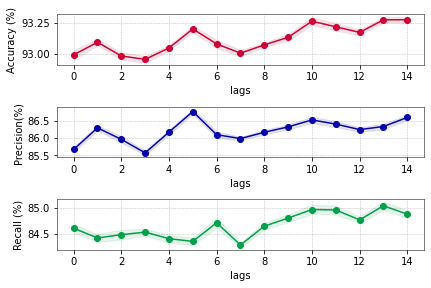

In [15]:
evaluar_modelo(clf2)

### Resultados LightGBM

Modelo: LGBMClassifier(learning_rate=0.5, n_estimators=20)
cross_val results para el conjunto de test para #lags: 1


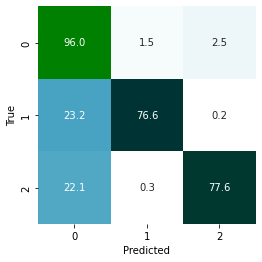

Modelo: LGBMClassifier(learning_rate=0.5, n_estimators=20)
cross_val results para el conjunto de test para #lags: 2


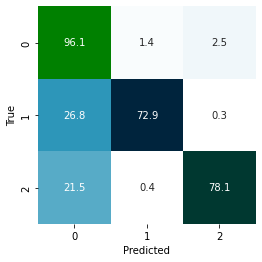

Modelo: LGBMClassifier(learning_rate=0.5, n_estimators=20)
cross_val results para el conjunto de test para #lags: 3


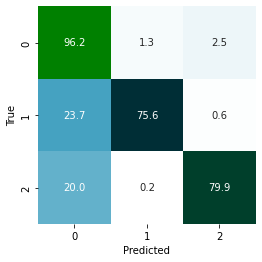

Modelo: LGBMClassifier(learning_rate=0.5, n_estimators=20)
cross_val results para el conjunto de test para #lags: 4


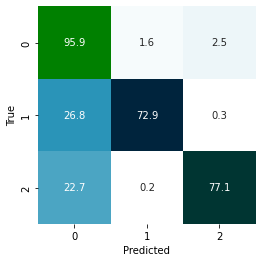

Modelo: LGBMClassifier(learning_rate=0.5, n_estimators=20)
cross_val results para el conjunto de test para #lags: 5


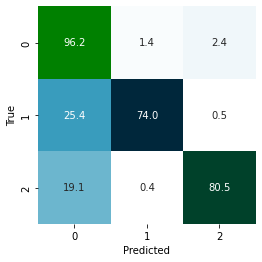

Modelo: LGBMClassifier(learning_rate=0.5, n_estimators=20)
cross_val results para el conjunto de test para #lags: 6


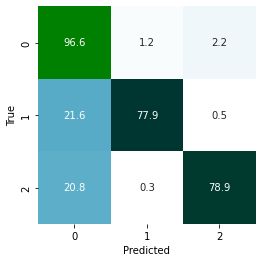

Modelo: LGBMClassifier(learning_rate=0.5, n_estimators=20)
cross_val results para el conjunto de test para #lags: 7


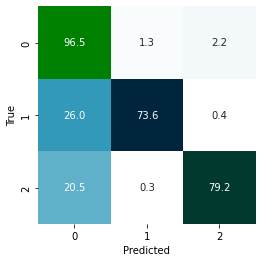

Modelo: LGBMClassifier(learning_rate=0.5, n_estimators=20)
cross_val results para el conjunto de test para #lags: 8


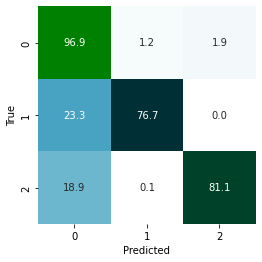

Modelo: LGBMClassifier(learning_rate=0.5, n_estimators=20)
cross_val results para el conjunto de test para #lags: 9


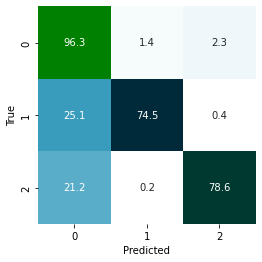

Modelo: LGBMClassifier(learning_rate=0.5, n_estimators=20)
cross_val results para el conjunto de test para #lags: 10


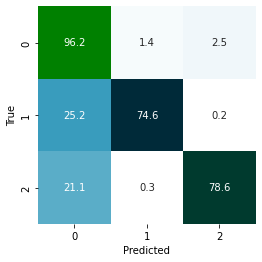

Modelo: LGBMClassifier(learning_rate=0.5, n_estimators=20)
cross_val results para el conjunto de test para #lags: 11


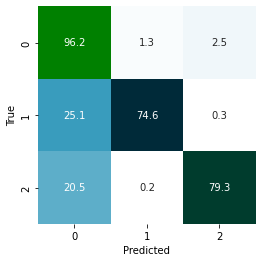

Modelo: LGBMClassifier(learning_rate=0.5, n_estimators=20)
cross_val results para el conjunto de test para #lags: 12


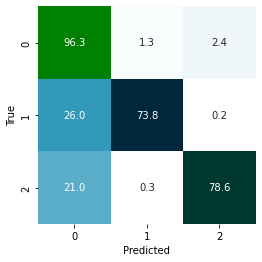

Modelo: LGBMClassifier(learning_rate=0.5, n_estimators=20)
cross_val results para el conjunto de test para #lags: 13


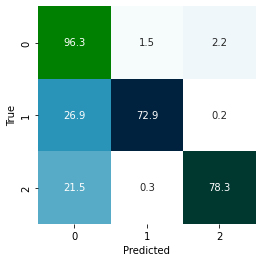

Modelo: LGBMClassifier(learning_rate=0.5, n_estimators=20)
cross_val results para el conjunto de test para #lags: 14


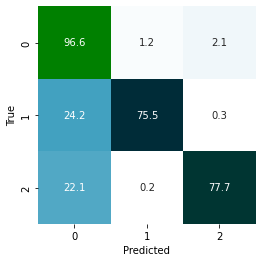

Modelo: LGBMClassifier(learning_rate=0.5, n_estimators=20)
cross_val results para el conjunto de test para #lags: 15


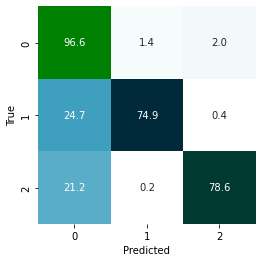

,Modelo,#lags,repeticiones,fit_time,score_time,test_accuracy,test_accuracy_desvest,train_accuracy,test_precision_macro,test_precision_macro_desvest,train_precision_macro,test_recall_macro,train_recall_macro,test_recall_macro_desvest,train_recall_macro_desvest
0,"LGBMClassifier(learning_rate=0.5, n_estimators...",1,15,0.301312,0.097745,0.930119,0.004993,0.954613,0.859919,0.015963,0.913211,0.847685,0.901888,0.008958,0.012166
1,"LGBMClassifier(learning_rate=0.5, n_estimators...",2,15,0.372922,0.096622,0.931257,0.003571,0.964653,0.865404,0.008878,0.936928,0.846926,0.922652,0.010666,0.006462
2,"LGBMClassifier(learning_rate=0.5, n_estimators...",3,15,0.534779,0.100412,0.927805,0.005819,0.965368,0.857699,0.021628,0.935601,0.837927,0.926424,0.009536,0.012066
3,"LGBMClassifier(learning_rate=0.5, n_estimators...",4,15,0.641309,0.099282,0.930144,0.002713,0.970758,0.865645,0.010147,0.950664,0.839381,0.935491,0.007404,0.011265
4,"LGBMClassifier(learning_rate=0.5, n_estimators...",5,15,0.780291,0.098484,0.928379,0.002288,0.971664,0.861465,0.007024,0.952423,0.837795,0.938817,0.007123,0.011242
5,"LGBMClassifier(learning_rate=0.5, n_estimators...",6,15,0.916812,0.100213,0.927602,0.003181,0.973005,0.859395,0.008613,0.955137,0.835482,0.941642,0.008390,0.009711
6,"LGBMClassifier(learning_rate=0.5, n_estimators...",7,15,1.127212,0.104070,0.927532,0.002447,0.972851,0.855739,0.007762,0.951737,0.838915,0.942644,0.007104,0.012247
7,"LGBMClassifier(learning_rate=0.5, n_estimators...",8,15,1.346457,0.099016,0.925971,0.002974,0.972944,0.853584,0.010608,0.951892,0.836995,0.942771,0.006931,0.010908
8,"LGBMClassifier(learning_rate=0.5, n_estimators...",9,15,1.559485,0.102209,0.927936,0.002605,0.976761,0.859262,0.008486,0.960717,0.837411,0.953517,0.005929,0.005595
9,"LGBMClassifier(learning_rate=0.5, n_estimators...",10,15,1.989828,0.116705,0.927919,0.003281,0.975990,0.856063,0.010325,0.957793,0.839440,0.948819,0.007419,0.011602


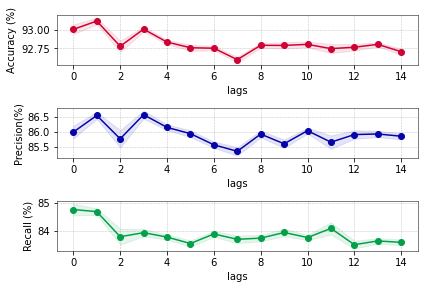

In [16]:
evaluar_modelo(clf3)

### Resultados Histogram Gradient Boosting

Modelo: HistGradientBoostingClassifier()
cross_val results para el conjunto de test para #lags: 1


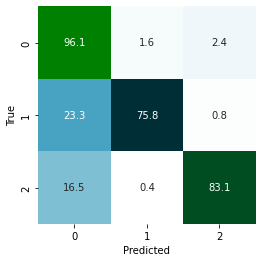

Modelo: HistGradientBoostingClassifier()
cross_val results para el conjunto de test para #lags: 2


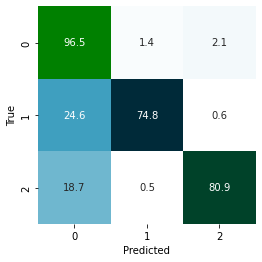

Modelo: HistGradientBoostingClassifier()
cross_val results para el conjunto de test para #lags: 3


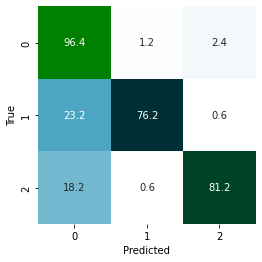

Modelo: HistGradientBoostingClassifier()
cross_val results para el conjunto de test para #lags: 4


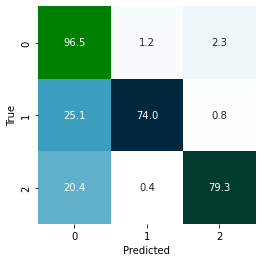

Modelo: HistGradientBoostingClassifier()
cross_val results para el conjunto de test para #lags: 5


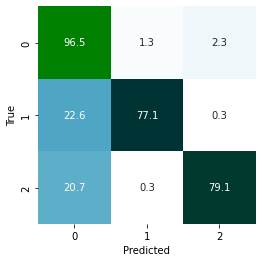

Modelo: HistGradientBoostingClassifier()
cross_val results para el conjunto de test para #lags: 6


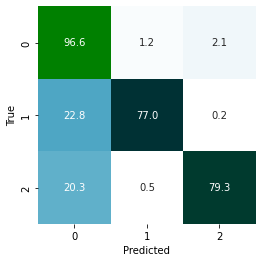

Modelo: HistGradientBoostingClassifier()
cross_val results para el conjunto de test para #lags: 7


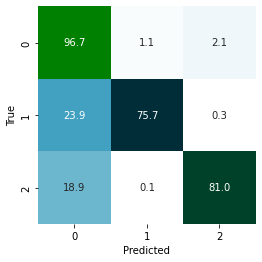

Modelo: HistGradientBoostingClassifier()
cross_val results para el conjunto de test para #lags: 8


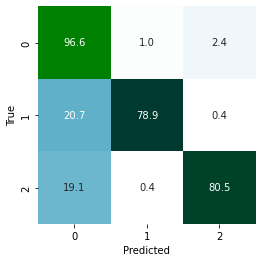

Modelo: HistGradientBoostingClassifier()
cross_val results para el conjunto de test para #lags: 9


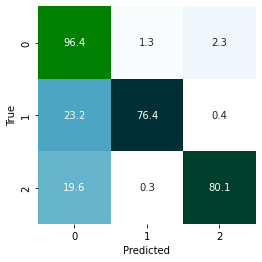

Modelo: HistGradientBoostingClassifier()
cross_val results para el conjunto de test para #lags: 10


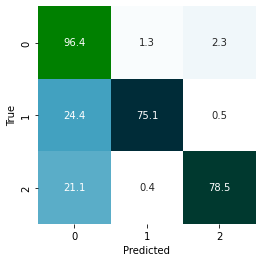

Modelo: HistGradientBoostingClassifier()
cross_val results para el conjunto de test para #lags: 11


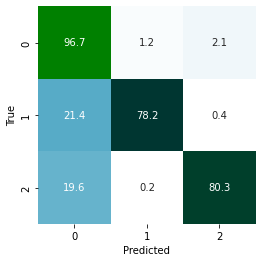

Modelo: HistGradientBoostingClassifier()
cross_val results para el conjunto de test para #lags: 12


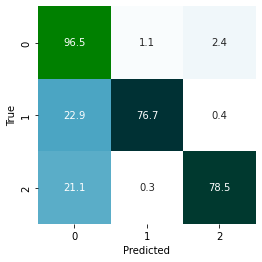

Modelo: HistGradientBoostingClassifier()
cross_val results para el conjunto de test para #lags: 13


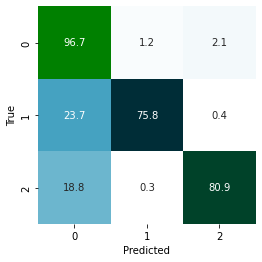

Modelo: HistGradientBoostingClassifier()
cross_val results para el conjunto de test para #lags: 14


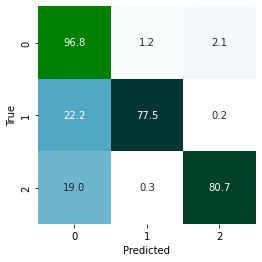

Modelo: HistGradientBoostingClassifier()
cross_val results para el conjunto de test para #lags: 15


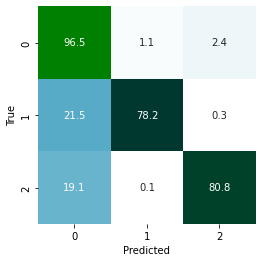

,Modelo,#lags,repeticiones,fit_time,score_time,test_accuracy,test_accuracy_desvest,train_accuracy,test_precision_macro,test_precision_macro_desvest,train_precision_macro,test_recall_macro,train_recall_macro,test_recall_macro_desvest,train_recall_macro_desvest
0,HistGradientBoostingClassifier(),1,15,2.569826,0.170435,0.935561,0.001609,0.952073,0.877347,0.004276,0.913449,0.859835,0.895382,0.005782,0.008716
1,HistGradientBoostingClassifier(),2,15,2.775439,0.167905,0.936205,0.002980,0.954464,0.879566,0.007100,0.916156,0.859688,0.900735,0.007314,0.006850
2,HistGradientBoostingClassifier(),3,15,3.376051,0.182273,0.935803,0.002520,0.957843,0.878310,0.006491,0.923007,0.855742,0.907794,0.004590,0.009854
3,HistGradientBoostingClassifier(),4,15,4.586520,0.235005,0.937026,0.002116,0.962155,0.880186,0.003820,0.929587,0.860097,0.921282,0.006109,0.008722
4,HistGradientBoostingClassifier(),5,15,4.492159,0.206543,0.935850,0.002109,0.961434,0.880092,0.005002,0.931118,0.853685,0.915404,0.005022,0.011467
5,HistGradientBoostingClassifier(),6,15,5.173933,0.243849,0.936395,0.002308,0.964510,0.880411,0.005708,0.936471,0.857251,0.923110,0.006413,0.011635
6,HistGradientBoostingClassifier(),7,15,5.799714,0.241589,0.936449,0.002084,0.966025,0.880557,0.004753,0.939077,0.856876,0.927582,0.007492,0.010227
7,HistGradientBoostingClassifier(),8,15,5.962037,0.238330,0.935110,0.002397,0.964746,0.877381,0.005930,0.936013,0.853379,0.924264,0.005698,0.009217
8,HistGradientBoostingClassifier(),9,15,6.948073,0.252627,0.937914,0.001903,0.968297,0.884685,0.004635,0.944631,0.859614,0.931990,0.005585,0.012799
9,HistGradientBoostingClassifier(),10,15,6.956984,0.242918,0.935970,0.002650,0.965099,0.880068,0.005939,0.938608,0.855863,0.924628,0.008242,0.009899


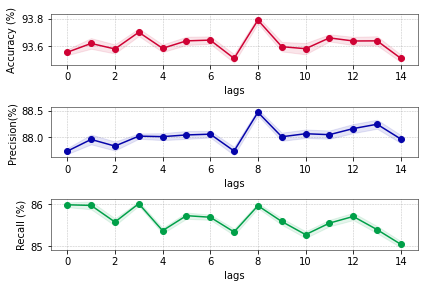

In [17]:
evaluar_modelo(clf4)

### RESULTADOS CLASIFICADOR POR MAYORIA DE VOTOS

Teniendo en cuenta que los métodos de ensemble por mayoría de votos utilizados en la exploración al tanteo arrojaron un incremento en las métricas de desempeño, observamos los resultados para un clasificador por mayoría de votos para los modelos con mejor desempeño:

In [18]:
#Definimos el max voting para los mismos clasificadores tratados en el numeral anterior
mv_skln=VotingClassifier(estimators=[('clf2', clf2), ('clf3', clf3), ('clf4', clf4)],voting='hard', weights=None)

Modelo: VotingClassifier(estimators=[('clf2',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.01, max_bin=None,
                                            max_cat_to_onehot=None,
                                        

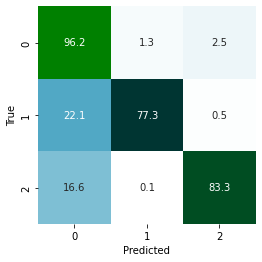

Modelo: VotingClassifier(estimators=[('clf2',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.01, max_bin=None,
                                            max_cat_to_onehot=None,
                                        

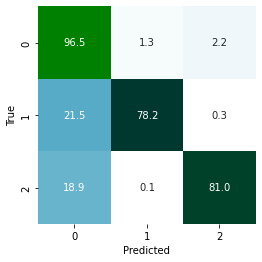

Modelo: VotingClassifier(estimators=[('clf2',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.01, max_bin=None,
                                            max_cat_to_onehot=None,
                                        

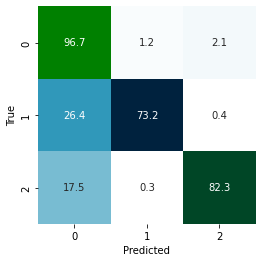

Modelo: VotingClassifier(estimators=[('clf2',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.01, max_bin=None,
                                            max_cat_to_onehot=None,
                                        

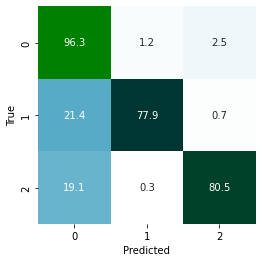

Modelo: VotingClassifier(estimators=[('clf2',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.01, max_bin=None,
                                            max_cat_to_onehot=None,
                                        

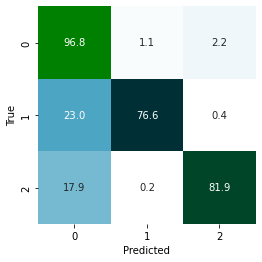

Modelo: VotingClassifier(estimators=[('clf2',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.01, max_bin=None,
                                            max_cat_to_onehot=None,
                                        

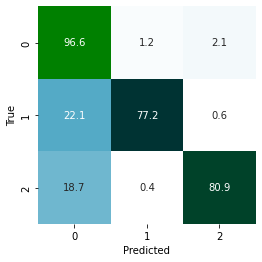

Modelo: VotingClassifier(estimators=[('clf2',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.01, max_bin=None,
                                            max_cat_to_onehot=None,
                                        

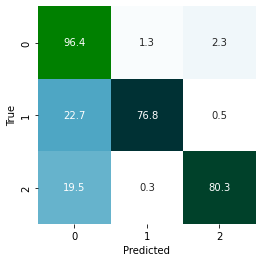

Modelo: VotingClassifier(estimators=[('clf2',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.01, max_bin=None,
                                            max_cat_to_onehot=None,
                                        

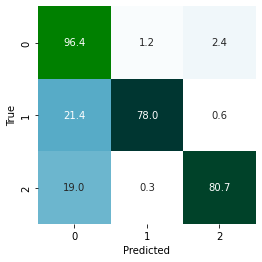

Modelo: VotingClassifier(estimators=[('clf2',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.01, max_bin=None,
                                            max_cat_to_onehot=None,
                                        

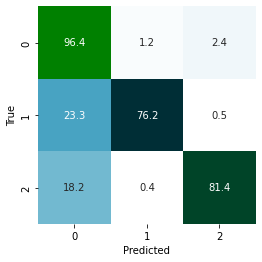

Modelo: VotingClassifier(estimators=[('clf2',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.01, max_bin=None,
                                            max_cat_to_onehot=None,
                                        

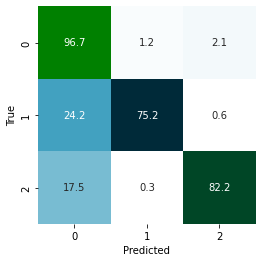

Modelo: VotingClassifier(estimators=[('clf2',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.01, max_bin=None,
                                            max_cat_to_onehot=None,
                                        

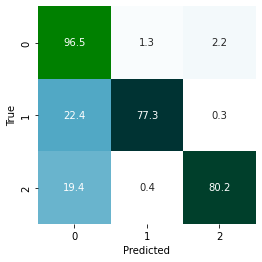

Modelo: VotingClassifier(estimators=[('clf2',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.01, max_bin=None,
                                            max_cat_to_onehot=None,
                                        

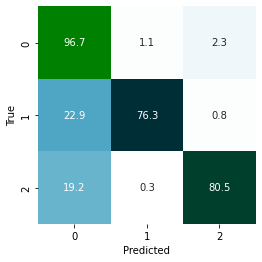

Modelo: VotingClassifier(estimators=[('clf2',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.01, max_bin=None,
                                            max_cat_to_onehot=None,
                                        

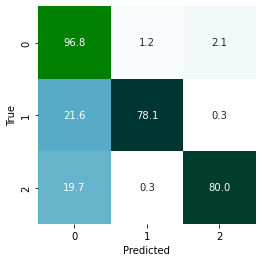

Modelo: VotingClassifier(estimators=[('clf2',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.01, max_bin=None,
                                            max_cat_to_onehot=None,
                                        

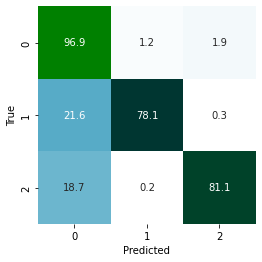

Modelo: VotingClassifier(estimators=[('clf2',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.01, max_bin=None,
                                            max_cat_to_onehot=None,
                                        

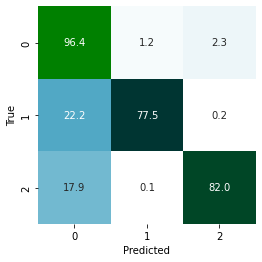

,Modelo,#lags,repeticiones,fit_time,score_time,test_accuracy,test_accuracy_desvest,train_accuracy,test_precision_macro,test_precision_macro_desvest,train_precision_macro,test_recall_macro,train_recall_macro,test_recall_macro_desvest,train_recall_macro_desvest
0,"VotingClassifier(estimators=[('clf2',\n ...",1,15,9.353424,0.354883,0.936496,0.001244,0.948771,0.876180,0.002608,0.903127,0.862772,0.889064,0.004102,0.004884
1,"VotingClassifier(estimators=[('clf2',\n ...",2,15,13.467739,0.378354,0.938331,0.001238,0.954773,0.881091,0.004976,0.916176,0.862124,0.898990,0.004977,0.005107
2,"VotingClassifier(estimators=[('clf2',\n ...",3,15,18.767696,0.393714,0.937776,0.002366,0.956618,0.881320,0.005922,0.920454,0.861641,0.905670,0.007686,0.007324
3,"VotingClassifier(estimators=[('clf2',\n ...",4,15,24.643828,0.482215,0.938114,0.001865,0.959077,0.882332,0.004638,0.926497,0.859647,0.908778,0.005175,0.006309
4,"VotingClassifier(estimators=[('clf2',\n ...",5,15,30.838679,0.476517,0.937370,0.001773,0.960079,0.881426,0.003825,0.928765,0.859761,0.911519,0.006515,0.005061
5,"VotingClassifier(estimators=[('clf2',\n ...",6,15,35.731124,0.506212,0.938277,0.002211,0.961570,0.884117,0.005125,0.932498,0.860297,0.914751,0.007353,0.008589
6,"VotingClassifier(estimators=[('clf2',\n ...",7,15,38.369574,0.476201,0.939176,0.002220,0.964313,0.885070,0.005490,0.936584,0.862459,0.921796,0.006298,0.007522
7,"VotingClassifier(estimators=[('clf2',\n ...",8,15,46.039316,0.531976,0.938925,0.002125,0.964652,0.884232,0.006219,0.937977,0.861007,0.921162,0.006855,0.008698
8,"VotingClassifier(estimators=[('clf2',\n ...",9,15,51.925980,0.561214,0.938005,0.001689,0.965774,0.883354,0.005089,0.939635,0.860996,0.925909,0.005292,0.010205
9,"VotingClassifier(estimators=[('clf2',\n ...",10,15,56.356719,0.705756,0.937648,0.001695,0.964898,0.882030,0.004601,0.937174,0.862013,0.924943,0.005656,0.006839


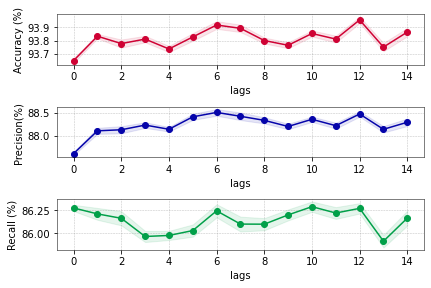

In [19]:
evaluar_modelo(mv_skln)

Observamos que todas las métricas de desempeño, incluyendo el recall promedio, muestran mejores resultados que en la evaluación de cada uno de los modelos por separado. Así mismo, la precisión para cada una de las categorías de arbitraje presenta una leve mejora. Así mismo, observamos con claridad un número de lags en el que se presentan los mejores resultados (lag 12). Por el momento, este modelo de clasificación por mayoría de votos presenta los resultados óptimos.  
En la siguiente sección, analizaremos el efecto de predicción a futuro para las condiciones de arbitraje. Si los resultados no son mejores, tomaremos el modelo de clasificación por mayoría de votos como modelo óptimo para la evaluación financiera.

### Modelos de evaluación a futuro

En esta sección aplicaremos la misma metodología de la sección anterior pero esta vez el target de predicción serán las condiciones de arbitraje a futuro. Para esto, construimos una base de datos con las condiciones actuales de precio y una serie de targets que reflejan las condiciones de arbitraje en las observaciones futuras. El objetivo será evaluar si las condiciones condiciones de precio actuales, no rezagadas, son un buen predictor para las condiciones de arbitraje futuras para un cierto horizonte de tiempo en el futuro.

### Definiciones

In [20]:
#Para la base original, agregamos una columna de arbitraje que diferencia la categoría de arbitraje en el momento actual.
base['Arbitraje']=None
for i in range(len(base)):
        if base['Arbitraje_BE_SL'].iloc[i]==1: 
            base['Arbitraje'].iloc[i]=1
        elif base['Arbitraje_BL_SE'].iloc[i]==1:
            base['Arbitraje'].iloc[i]=2
        else:
            base['Arbitraje'].iloc[i]=0
    

C:\Users\fract\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [21]:
#Definimos una función que aplica un horizonte de tiempo futuro (también lo llamamos lags) a la serie de Arbitrajes
def add_lags_arb(data, lags):
    cols = []
    df=pd.DataFrame(base['Arbitraje']) 
    for lag in range(1, lags + 1):
        col = 'lag_arb_{}'.format(lag)+'_'+'Arbitraje'  # defines the column name
        df[col] = df['Arbitraje'].shift(-lag)  # creates the lagged data column
        cols.append(col)  # stores the column name
    df.dropna(inplace=True)  # gets rid of incomplete data rows
    return df, cols

In [22]:
#Observamos las columnas de horizonte de tiempo para una y dos observaciones
add_lags_arb(base, 2)[0][10:20]

,Arbitraje,lag_arb_1_Arbitraje,lag_arb_2_Arbitraje
10,2,2,0
11,2,0,0
12,0,0,2
13,0,2,2
14,2,2,0
15,2,0,0
16,0,0,0
17,0,0,0
18,0,0,0
19,0,0,0


### Creación de la base de datos

In [23]:
#Definimos una función para crear una base de datos que incluya las condiciones de arbitraje futuras para un número de lags
def base_lags_arb(base_all,lags):
    base_lags=add_lags_arb(base_all,lags)[0]
    return pd.concat([base_all.iloc[:len(base_all)-lags,:],base_lags],axis=1,join='outer')

In [24]:
base_lags_arb(base,2)

,Unnamed: 0,Date,Hora_COL,Minuto,Hora_NY,Festivo_COL,Festivo_NYSE,Next_Day,Subasta,PFB_ABIERTO,...,ASK_PFB,BID_PFB,Spread_BE_SL,Spread_BL_SE,Arbitraje_BE_SL,Arbitraje_BL_SE,Arbitraje,Arbitraje,lag_arb_1_Arbitraje,lag_arb_2_Arbitraje
0,0,2022-01-03,9,54,9,False,False,0,0,1,...,32300,32010,-352.32380,-186.301250,0,0,0,0,0,0
1,1,2022-01-03,9,55,9,False,False,0,0,1,...,32300,32290,-75.37175,-157.967540,0,0,0,0,0,0
2,2,2022-01-03,9,56,9,False,False,0,0,1,...,32300,32290,-85.56300,-137.606440,0,0,0,0,0,0
3,3,2022-01-03,9,57,9,False,False,0,0,1,...,32300,32290,-77.62100,-137.606440,0,0,0,0,0,0
4,4,2022-01-03,9,58,9,False,False,0,0,1,...,32300,32290,-77.62100,-122.935500,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50399,50399,2022-05-12,12,53,13,False,False,0,0,1,...,37690,37610,-125.24335,-44.626300,0,0,0,0,0,0
50400,50400,2022-05-12,12,54,13,False,False,0,0,1,...,37690,37610,-124.76379,-47.130625,0,0,0,0,0,0
50401,50401,2022-05-12,12,55,13,False,False,0,0,1,...,37690,37610,-115.66425,-96.268000,0,0,0,0,0,0
50402,50402,2022-05-12,12,56,13,False,False,0,0,1,...,37680,37610,-115.66425,-81.699000,0,0,0,0,0,0


Para la evaluación del modelo a futuro, necesitamos una serie de targets a futuro, para lo cual creamos una base de datos con 15 targets, cada uno reflejando las condiciones de arbitraje en un múmero determinado de observaciones futuras. Tal como hicimos en la sección anterior, elegimos una evaluación para 15 observaciones en el futuro (también las llamamos lags).

In [25]:
#Creamos una base de datos para un horizonte de tiempo de 15 observaciones futuras (los llamamos lags)
lags_15=base_lags_arb(base,15)

In [26]:
lags_15.columns

Index(['Unnamed: 0', 'Date', 'Hora_COL', 'Minuto', 'Hora_NY', 'Festivo_COL',
       'Festivo_NYSE', 'Next_Day', 'Subasta', 'PFB_ABIERTO', 'CIB_ABIERTO',
       'CIB_close', 'COP_close', 'PFB_close', 'SPX_close', 'tasa_cambio',
       'USD_BID', 'USD_ASK', 'ASK_CIB', 'BID_CIB', 'ASK_PFB', 'BID_PFB',
       'Spread_BE_SL', 'Spread_BL_SE', 'Arbitraje_BE_SL', 'Arbitraje_BL_SE',
       'Arbitraje', 'Arbitraje', 'lag_arb_1_Arbitraje', 'lag_arb_2_Arbitraje',
       'lag_arb_3_Arbitraje', 'lag_arb_4_Arbitraje', 'lag_arb_5_Arbitraje',
       'lag_arb_6_Arbitraje', 'lag_arb_7_Arbitraje', 'lag_arb_8_Arbitraje',
       'lag_arb_9_Arbitraje', 'lag_arb_10_Arbitraje', 'lag_arb_11_Arbitraje',
       'lag_arb_12_Arbitraje', 'lag_arb_13_Arbitraje', 'lag_arb_14_Arbitraje',
       'lag_arb_15_Arbitraje'],
      dtype='object')

In [27]:
#El objetivo es predecir las columnas de horizontes futuros para las condiciones de arbitraje
columnas_target=['lag_arb_1_Arbitraje', 'lag_arb_2_Arbitraje',
       'lag_arb_3_Arbitraje', 'lag_arb_4_Arbitraje', 'lag_arb_5_Arbitraje',
       'lag_arb_6_Arbitraje', 'lag_arb_7_Arbitraje', 'lag_arb_8_Arbitraje',
       'lag_arb_9_Arbitraje', 'lag_arb_10_Arbitraje', 'lag_arb_11_Arbitraje',
       'lag_arb_12_Arbitraje', 'lag_arb_13_Arbitraje', 'lag_arb_14_Arbitraje',
       'lag_arb_15_Arbitraje']

In [28]:
#Columnas que no tendremos en cuenta para la evaluación de los modelos
sobrantes=columnas_fecha+columnas_target

In [29]:
sobrantes

['Date',
 'Hora_COL',
 'Minuto',
 'Hora_NY',
 'Festivo_COL',
 'Festivo_NYSE',
 'Next_Day',
 'Subasta',
 'PFB_ABIERTO',
 'CIB_ABIERTO',
 'lag_arb_1_Arbitraje',
 'lag_arb_2_Arbitraje',
 'lag_arb_3_Arbitraje',
 'lag_arb_4_Arbitraje',
 'lag_arb_5_Arbitraje',
 'lag_arb_6_Arbitraje',
 'lag_arb_7_Arbitraje',
 'lag_arb_8_Arbitraje',
 'lag_arb_9_Arbitraje',
 'lag_arb_10_Arbitraje',
 'lag_arb_11_Arbitraje',
 'lag_arb_12_Arbitraje',
 'lag_arb_13_Arbitraje',
 'lag_arb_14_Arbitraje',
 'lag_arb_15_Arbitraje']

In [30]:
#Creamos la base de features, eliminando las columnas que no son de interés y estandarizamos
X=lags_15.drop(sobrantes,axis=1)
X_std=StandardScaler().fit_transform(X)

In [31]:
#Número de observaciones para un horizonte de tiempo de 15 observaciones
len(X_std)

50391

In [32]:
#Condiciones de Arbitraje dentro de 15 observaciones futuras para las condiciones actuales de precio
lags_15['lag_arb_2_Arbitraje']

0        0
1        0
2        0
3        0
4        0
        ..
50386    0
50387    0
50388    2
50389    2
50390    0
Name: lag_arb_2_Arbitraje, Length: 50391, dtype: object

In [33]:
#Columnas de targets
columnas_target

['lag_arb_1_Arbitraje',
 'lag_arb_2_Arbitraje',
 'lag_arb_3_Arbitraje',
 'lag_arb_4_Arbitraje',
 'lag_arb_5_Arbitraje',
 'lag_arb_6_Arbitraje',
 'lag_arb_7_Arbitraje',
 'lag_arb_8_Arbitraje',
 'lag_arb_9_Arbitraje',
 'lag_arb_10_Arbitraje',
 'lag_arb_11_Arbitraje',
 'lag_arb_12_Arbitraje',
 'lag_arb_13_Arbitraje',
 'lag_arb_14_Arbitraje',
 'lag_arb_15_Arbitraje']

### Evaluación de modelos para condiciones de arbitraje a futuro

La evaluación procede de forma similar a la realizada con la base de rezagos en los precios: para cada columna en los targets, aplicamos un cross validation estratificado repetido con tres splits y cinco repeticiones.Tabulamos y observamos los resultados.

In [34]:
# Imports
from sklearn.utils.multiclass import type_of_target

In [35]:
#Definimos el codificador de arbitrajes para las variables de target
label_encoder = LabelEncoder()

In [36]:
def evaluar_adelante(modelo):
    resultados=pd.DataFrame(columns=['Modelo','#lags','repeticiones','fit_time', 'score_time',
                                     'test_accuracy', 'test_accuracy_desvest', 'train_accuracy','test_precision_macro', 'test_precision_macro_desvest',
                                     'train_precision_macro','test_recall_macro', 'train_recall_macro'])
    i=0
    for target in columnas_target:
        
        targ=label_encoder.fit_transform(lags_15[target])
        X_train, X_test, y_train, y_test = train_test_split(X_std, targ, test_size=0.3, random_state=None, stratify=lags_15[target], shuffle=True)
        print(type_of_target(y_train))
    
        folds=range(0,1)
        accuracy_scores=[]
        precision_scores=[]
        recall_scores=[]   
        for fold in folds:   
            
            cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=123)
            cv_scores = cross_validate(
                    estimator = modelo,
                    X         = X_train,
                    y         = y_train,
                    scoring   =('accuracy','precision_macro', 'recall_macro', 'f1_macro'),
                    cv        = cv,
                    return_train_score = True
                )

            cv_scores = pd.DataFrame(cv_scores)

            resultados=resultados.append({'Modelo': modelo,'#lags': i+1,'repeticiones': len(cv_scores),
                                          'fit_time': cv_scores['fit_time'].mean(),'score_time': cv_scores['score_time'].mean(),
                                          'test_accuracy': cv_scores['test_accuracy'].mean(),
                                          'test_accuracy_desvest': cv_scores['test_accuracy'].std(), 
                                          'train_accuracy': cv_scores['train_accuracy'].mean(),
                                          'test_precision_macro': cv_scores['test_precision_macro'].mean(),
                                          'test_precision_macro_desvest': cv_scores['test_precision_macro'].std(),
                                          'train_precision_macro': cv_scores['train_precision_macro'].mean(),
                                          'test_recall_macro': cv_scores['test_recall_macro'].mean(),
                                          'train_recall_macro': cv_scores['train_recall_macro'].mean()}, ignore_index=True)

            #Realizamos prueba con el conjunto de test, e imprimimos la matriz de confusión para las predicciones
            y_pred = cross_val_predict(modelo, X_test,y_test,cv=StratifiedKFold(n_splits=3, shuffle=True))
            print(f'cross_val results para el conjunto de test para # lags a futuro: {i+1}')
            plotCM(y_test,y_pred, normalize=True)
            i+=1
    
    t=np.arange(len(lags))
    ci_acc=1.96* 100*resultados['test_accuracy_desvest'] / 15
    ci_prec=1.96* 100*resultados['test_precision_macro_desvest'] / 15
    ci_recall=1.96* 100*resultados['test_precision_macro_desvest'] / 15
    
    fig, axes = plt.subplots(3, 1)

    axes[0].plot(t, 100*resultados['test_accuracy'] , color = 'xkcd:cherry' , marker = 'o')
    axes[0].fill_between(t,(100*resultados['test_accuracy']-ci_acc), (100*resultados['test_accuracy']+ci_acc), color='xkcd:cherry', alpha=0.1)
    axes[0].set_xlabel('lags')
    axes[0].set_ylabel('Accuracy (%)')
    axes[0].set_facecolor((1,1,1))
    axes[0].spines['left'].set_color('black')
    axes[0].spines['right'].set_color('black')
    axes[0].spines['top'].set_color('black')
    axes[0].spines['bottom'].set_color('black')
    axes[0].spines['left'].set_linewidth(0.5)
    axes[0].spines['right'].set_linewidth(0.5)
    axes[0].spines['top'].set_linewidth(0.5)
    axes[0].spines['bottom'].set_linewidth(0.5)
    axes[0].grid(linestyle='--', linewidth='0.5', color='grey', alpha=0.5)

    axes[1].plot(t,100*resultados['test_precision_macro'] , color = 'xkcd:royal blue' , marker = 'o')
    axes[1].fill_between(t,(100*resultados['test_precision_macro']-ci_prec), (100*resultados['test_precision_macro']+ci_prec), color='xkcd:royal blue', alpha=0.1)
    axes[1].set_xlabel('lags')
    axes[1].set_ylabel('Precision(%)')
    axes[1].set_facecolor((1,1,1))
    axes[1].spines['left'].set_color('black')
    axes[1].spines['right'].set_color('black')
    axes[1].spines['top'].set_color('black')
    axes[1].spines['bottom'].set_color('black')
    axes[1].spines['left'].set_linewidth(0.5)
    axes[1].spines['right'].set_linewidth(0.5)
    axes[1].spines['top'].set_linewidth(0.5)
    axes[1].spines['bottom'].set_linewidth(0.5)
    axes[1].grid(linestyle='--', linewidth='0.5', color='grey', alpha=0.5)

    axes[2].plot(100*resultados['test_recall_macro'] , color = 'xkcd:emerald' , marker = 'o')
    axes[2].fill_between(t,(100*resultados['test_recall_macro']-ci_recall), (100*resultados['test_recall_macro']+ci_recall), color='xkcd:emerald', alpha=0.1)
    axes[2].set_xlabel('Repetition')
    axes[2].set_ylabel('Recall (%)')
    axes[2].set_facecolor((1,1,1))
    axes[2].spines['left'].set_color('black')
    axes[2].spines['right'].set_color('black')
    axes[2].spines['top'].set_color('black')
    axes[2].spines['bottom'].set_color('black')
    axes[2].spines['left'].set_linewidth(0.5)
    axes[2].spines['right'].set_linewidth(0.5)
    axes[2].spines['top'].set_linewidth(0.5)
    axes[2].spines['bottom'].set_linewidth(0.5)
    axes[2].grid(linestyle='--', linewidth='0.5', color='grey', alpha=0.5)

    plt.grid(True)
    plt.tight_layout()
    return resultados



        

### Evalación a futuro para Random Forest

multiclass
cross_val results para el conjunto de test para # lags a futuro: 1


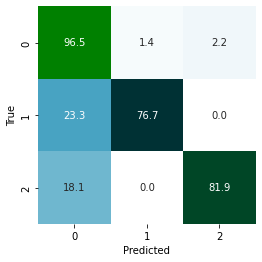

multiclass
cross_val results para el conjunto de test para # lags a futuro: 2


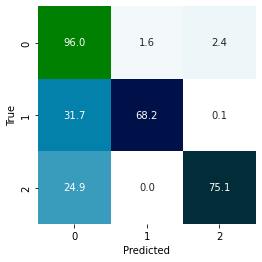

multiclass
cross_val results para el conjunto de test para # lags a futuro: 3


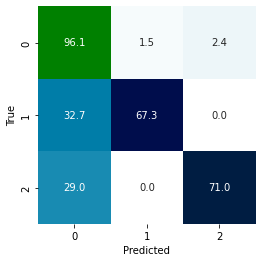

multiclass
cross_val results para el conjunto de test para # lags a futuro: 4


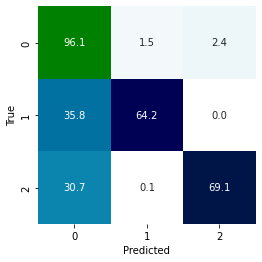

multiclass
cross_val results para el conjunto de test para # lags a futuro: 5


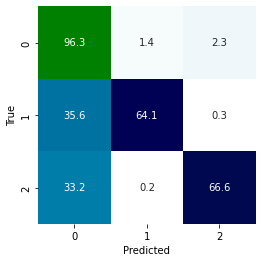

multiclass
cross_val results para el conjunto de test para # lags a futuro: 6


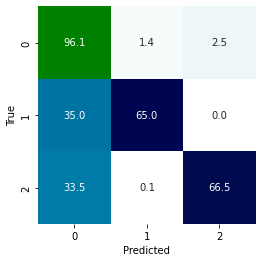

multiclass
cross_val results para el conjunto de test para # lags a futuro: 7


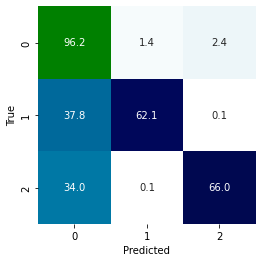

multiclass
cross_val results para el conjunto de test para # lags a futuro: 8


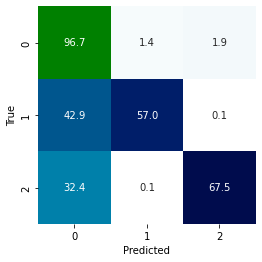

multiclass
cross_val results para el conjunto de test para # lags a futuro: 9


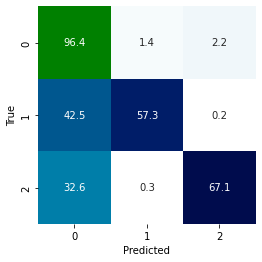

multiclass
cross_val results para el conjunto de test para # lags a futuro: 10


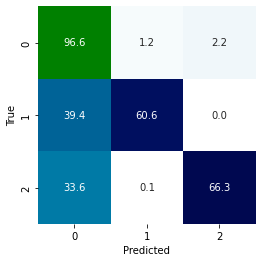

multiclass
cross_val results para el conjunto de test para # lags a futuro: 11


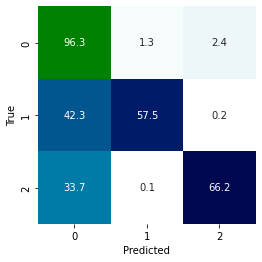

multiclass
cross_val results para el conjunto de test para # lags a futuro: 12


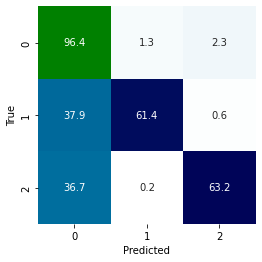

multiclass
cross_val results para el conjunto de test para # lags a futuro: 13


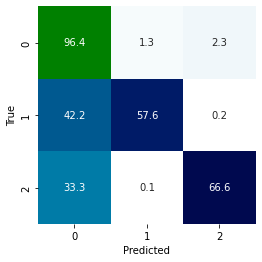

multiclass
cross_val results para el conjunto de test para # lags a futuro: 14


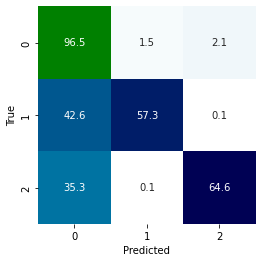

multiclass
cross_val results para el conjunto de test para # lags a futuro: 15


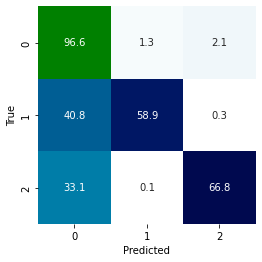

,Modelo,#lags,repeticiones,fit_time,score_time,test_accuracy,test_accuracy_desvest,train_accuracy,test_precision_macro,test_precision_macro_desvest,train_precision_macro,test_recall_macro,train_recall_macro
0,"RandomForestClassifier(max_depth=100, random_s...",1,15,0.893345,0.105052,0.933076,0.001919,0.997480,0.873038,0.005763,0.996110,0.852139,0.993051
1,"RandomForestClassifier(max_depth=100, random_s...",2,15,1.001057,0.113762,0.921101,0.001403,0.997431,0.854313,0.005412,0.996170,0.813618,0.992535
2,"RandomForestClassifier(max_depth=100, random_s...",3,15,1.056243,0.116023,0.915425,0.002057,0.997012,0.847968,0.005035,0.995876,0.792681,0.990757
3,"RandomForestClassifier(max_depth=100, random_s...",4,15,1.075325,0.117685,0.915924,0.001980,0.996950,0.853057,0.004724,0.995783,0.786310,0.990160
4,"RandomForestClassifier(max_depth=100, random_s...",5,15,1.048128,0.114826,0.916576,0.002232,0.996604,0.857078,0.006183,0.995438,0.784525,0.989677
5,"RandomForestClassifier(max_depth=100, random_s...",6,15,1.073995,0.116422,0.917229,0.002435,0.996623,0.860263,0.007147,0.995197,0.782722,0.989314
6,"RandomForestClassifier(max_depth=100, random_s...",7,15,1.174593,0.130385,0.916599,0.001834,0.996388,0.858523,0.006552,0.994327,0.779126,0.989357
7,"RandomForestClassifier(max_depth=100, random_s...",8,15,1.108365,0.118948,0.914864,0.001413,0.996839,0.857154,0.005625,0.995354,0.779579,0.990401
8,"RandomForestClassifier(max_depth=100, random_s...",9,15,1.152120,0.121944,0.913894,0.001590,0.996462,0.855514,0.004883,0.994271,0.774683,0.990097
9,"RandomForestClassifier(max_depth=100, random_s...",10,15,1.123529,0.126861,0.914552,0.002134,0.996383,0.858225,0.007021,0.994414,0.775015,0.989365


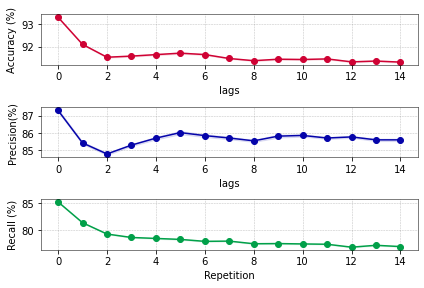

In [37]:
evaluar_adelante(clf1)

### Evaluación a Futuro para Gradient Boosting

multiclass
cross_val results para el conjunto de test para # lags a futuro: 1


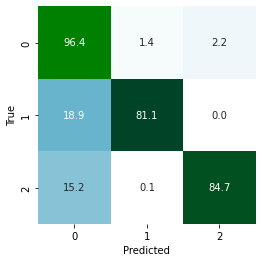

multiclass
cross_val results para el conjunto de test para # lags a futuro: 2


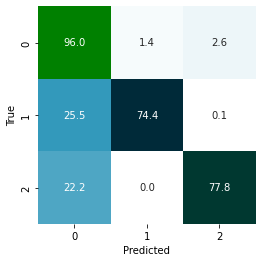

multiclass
cross_val results para el conjunto de test para # lags a futuro: 3


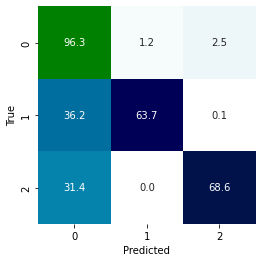

multiclass
cross_val results para el conjunto de test para # lags a futuro: 4


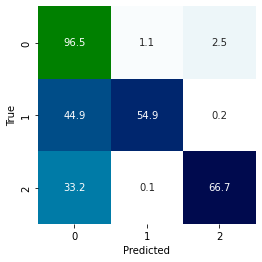

multiclass
cross_val results para el conjunto de test para # lags a futuro: 5


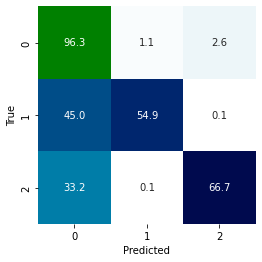

multiclass
cross_val results para el conjunto de test para # lags a futuro: 6


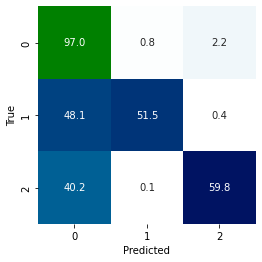

multiclass
cross_val results para el conjunto de test para # lags a futuro: 7


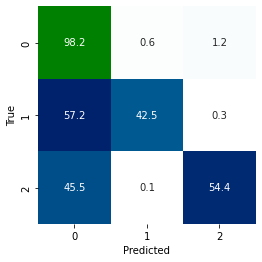

multiclass
cross_val results para el conjunto de test para # lags a futuro: 8


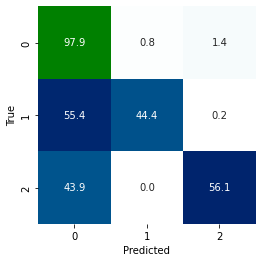

multiclass
cross_val results para el conjunto de test para # lags a futuro: 9


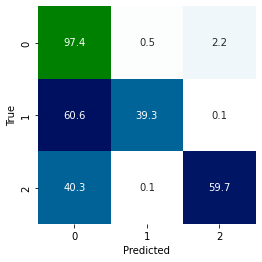

multiclass
cross_val results para el conjunto de test para # lags a futuro: 10


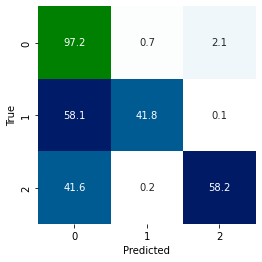

multiclass
cross_val results para el conjunto de test para # lags a futuro: 11


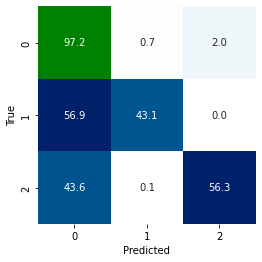

multiclass
cross_val results para el conjunto de test para # lags a futuro: 12


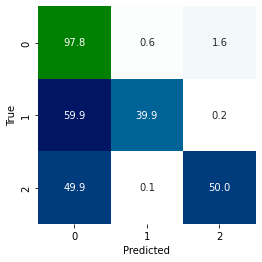

multiclass
cross_val results para el conjunto de test para # lags a futuro: 13


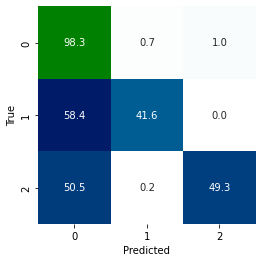

multiclass
cross_val results para el conjunto de test para # lags a futuro: 14


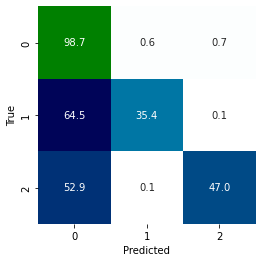

multiclass
cross_val results para el conjunto de test para # lags a futuro: 15


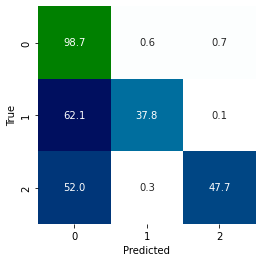

,Modelo,#lags,repeticiones,fit_time,score_time,test_accuracy,test_accuracy_desvest,train_accuracy,test_precision_macro,test_precision_macro_desvest,train_precision_macro,test_recall_macro,train_recall_macro
0,"XGBClassifier(base_score=None, booster=None, c...",1,15,6.485126,0.058910,0.940045,0.001894,0.940572,0.878914,0.004711,0.880332,0.878435,0.879411
1,"XGBClassifier(base_score=None, booster=None, c...",2,15,6.582401,0.058444,0.916457,0.002447,0.918825,0.837591,0.008027,0.843627,0.815685,0.820540
2,"XGBClassifier(base_score=None, booster=None, c...",3,15,6.545037,0.059040,0.907232,0.003129,0.909648,0.829075,0.009795,0.836047,0.776523,0.781459
3,"XGBClassifier(base_score=None, booster=None, c...",4,15,6.668103,0.057181,0.903898,0.002631,0.907334,0.840931,0.007677,0.849861,0.744786,0.751432
4,"XGBClassifier(base_score=None, booster=None, c...",5,15,6.549155,0.056383,0.899220,0.003638,0.903150,0.837418,0.009827,0.849090,0.720198,0.728055
5,"XGBClassifier(base_score=None, booster=None, c...",6,15,6.567771,0.056716,0.897134,0.002341,0.900162,0.838067,0.009757,0.846938,0.706726,0.713481
6,"XGBClassifier(base_score=None, booster=None, c...",7,15,6.610161,0.057181,0.894560,0.001685,0.898265,0.845941,0.010294,0.858300,0.686102,0.693395
7,"XGBClassifier(base_score=None, booster=None, c...",8,15,6.585325,0.055619,0.892541,0.002050,0.896502,0.856328,0.016516,0.868743,0.667926,0.676813
8,"XGBClassifier(base_score=None, booster=None, c...",9,15,6.614580,0.060638,0.892603,0.001647,0.895923,0.857179,0.012991,0.866899,0.666153,0.673938
9,"XGBClassifier(base_score=None, booster=None, c...",10,15,6.603207,0.056050,0.889610,0.002029,0.892966,0.866181,0.016434,0.878458,0.643766,0.651205


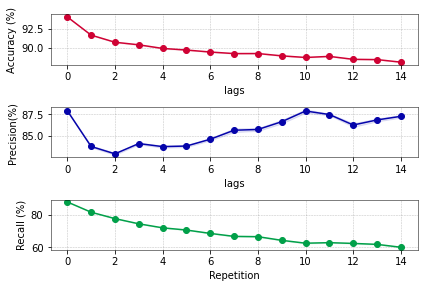

In [38]:
evaluar_adelante(clf2)

### Evaluación a Futuro para LightGBM

multiclass
cross_val results para el conjunto de test para # lags a futuro: 1


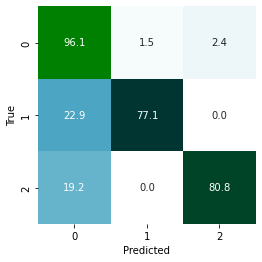

multiclass
cross_val results para el conjunto de test para # lags a futuro: 2


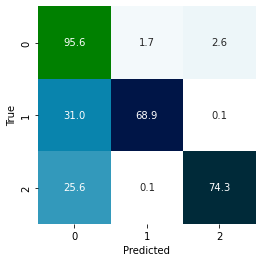

multiclass
cross_val results para el conjunto de test para # lags a futuro: 3


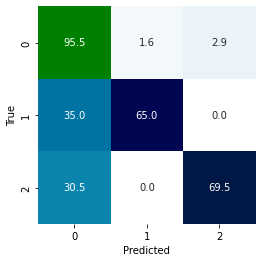

multiclass
cross_val results para el conjunto de test para # lags a futuro: 4


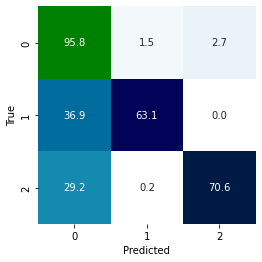

multiclass
cross_val results para el conjunto de test para # lags a futuro: 5


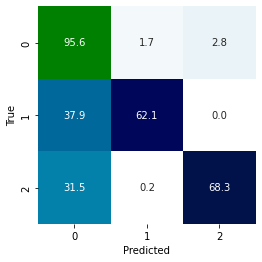

multiclass
cross_val results para el conjunto de test para # lags a futuro: 6


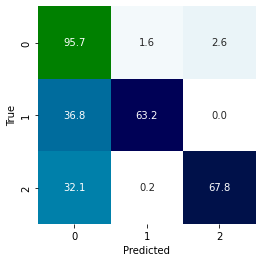

multiclass
cross_val results para el conjunto de test para # lags a futuro: 7


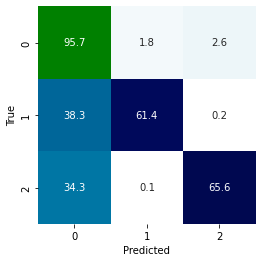

multiclass
cross_val results para el conjunto de test para # lags a futuro: 8


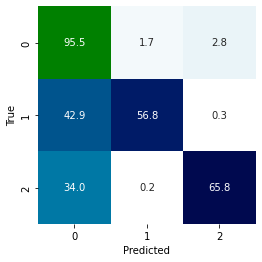

multiclass
cross_val results para el conjunto de test para # lags a futuro: 9


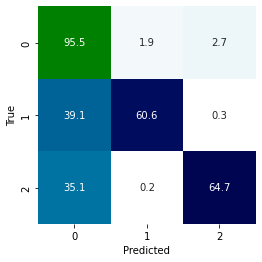

multiclass
cross_val results para el conjunto de test para # lags a futuro: 10


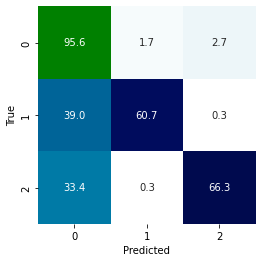

multiclass
cross_val results para el conjunto de test para # lags a futuro: 11


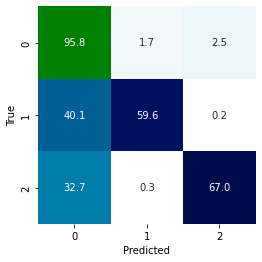

multiclass
cross_val results para el conjunto de test para # lags a futuro: 12


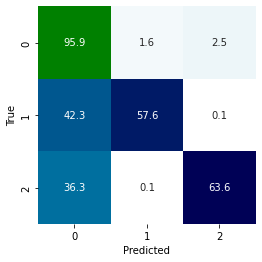

multiclass
cross_val results para el conjunto de test para # lags a futuro: 13


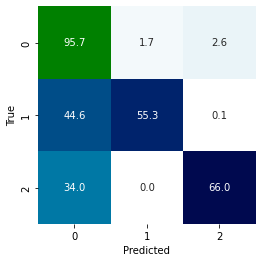

multiclass
cross_val results para el conjunto de test para # lags a futuro: 14


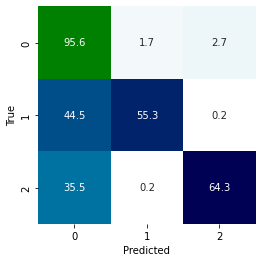

multiclass
cross_val results para el conjunto de test para # lags a futuro: 15


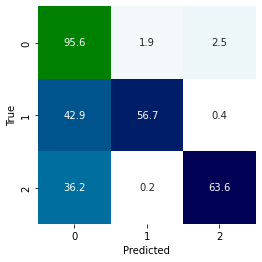

,Modelo,#lags,repeticiones,fit_time,score_time,test_accuracy,test_accuracy_desvest,train_accuracy,test_precision_macro,test_precision_macro_desvest,train_precision_macro,test_recall_macro,train_recall_macro
0,"LGBMClassifier(learning_rate=0.5, n_estimators...",1,15,0.287963,0.049801,0.932725,0.005326,0.962226,0.869089,0.014216,0.932272,0.852716,0.917949
1,"LGBMClassifier(learning_rate=0.5, n_estimators...",2,15,0.276195,0.050731,0.915777,0.002018,0.952805,0.840732,0.006404,0.920452,0.802323,0.884296
2,"LGBMClassifier(learning_rate=0.5, n_estimators...",3,15,0.284307,0.049402,0.909897,0.003110,0.946857,0.832901,0.007755,0.914609,0.781192,0.864129
3,"LGBMClassifier(learning_rate=0.5, n_estimators...",4,15,0.276394,0.050864,0.906013,0.003134,0.941859,0.829408,0.012426,0.909339,0.766114,0.847427
4,"LGBMClassifier(learning_rate=0.5, n_estimators...",5,15,0.277126,0.051231,0.907192,0.002827,0.943271,0.833601,0.008437,0.914852,0.764419,0.846358
5,"LGBMClassifier(learning_rate=0.5, n_estimators...",6,15,0.283110,0.051130,0.906376,0.002813,0.942112,0.834122,0.010197,0.915606,0.756062,0.839499
6,"LGBMClassifier(learning_rate=0.5, n_estimators...",7,15,0.278322,0.051263,0.905060,0.002389,0.940515,0.832221,0.008840,0.913358,0.755155,0.836431
7,"LGBMClassifier(learning_rate=0.5, n_estimators...",8,15,0.275397,0.050731,0.903518,0.008256,0.939909,0.829834,0.026167,0.912354,0.749392,0.835429
8,"LGBMClassifier(learning_rate=0.5, n_estimators...",9,15,0.276926,0.052393,0.902940,0.002994,0.939498,0.830524,0.007502,0.913866,0.744472,0.830239
9,"LGBMClassifier(learning_rate=0.5, n_estimators...",10,15,0.283176,0.052127,0.901222,0.004281,0.937232,0.826098,0.014446,0.908892,0.740323,0.825032


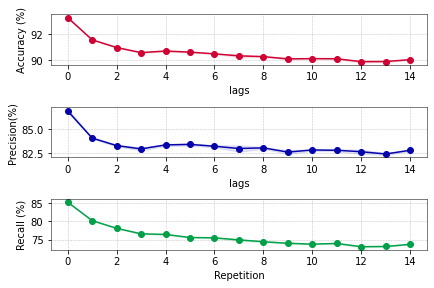

In [39]:
evaluar_adelante(clf3)

### Evaluación a Futuro para Histogram Gradient Boosting

multiclass
cross_val results para el conjunto de test para # lags a futuro: 1


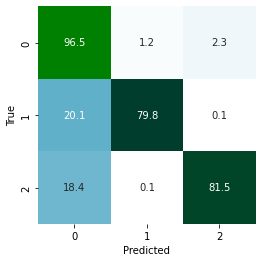

multiclass
cross_val results para el conjunto de test para # lags a futuro: 2


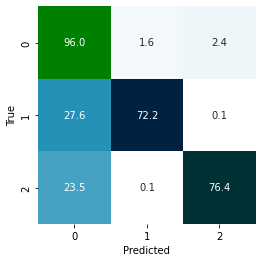

multiclass
cross_val results para el conjunto de test para # lags a futuro: 3


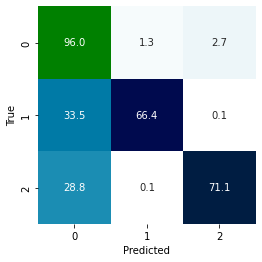

multiclass
cross_val results para el conjunto de test para # lags a futuro: 4


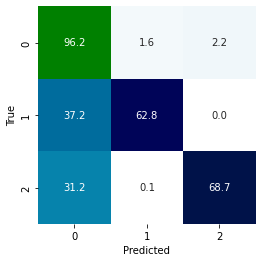

multiclass
cross_val results para el conjunto de test para # lags a futuro: 5


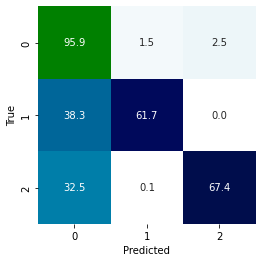

multiclass
cross_val results para el conjunto de test para # lags a futuro: 6


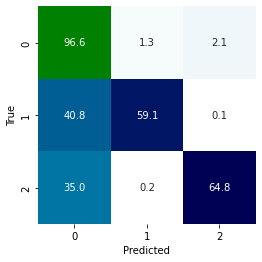

multiclass
cross_val results para el conjunto de test para # lags a futuro: 7


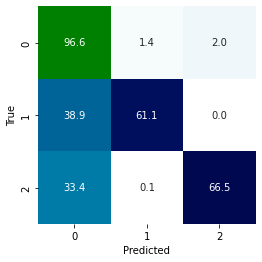

multiclass
cross_val results para el conjunto de test para # lags a futuro: 8


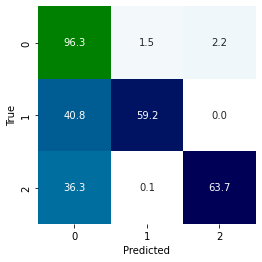

multiclass
cross_val results para el conjunto de test para # lags a futuro: 9


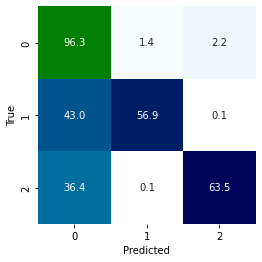

multiclass
cross_val results para el conjunto de test para # lags a futuro: 10


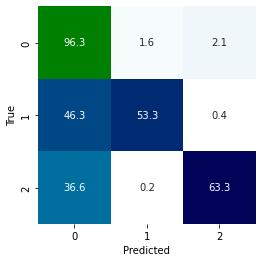

multiclass
cross_val results para el conjunto de test para # lags a futuro: 11


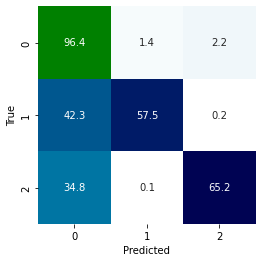

multiclass
cross_val results para el conjunto de test para # lags a futuro: 12


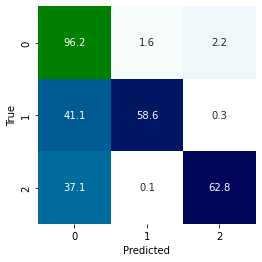

multiclass
cross_val results para el conjunto de test para # lags a futuro: 13


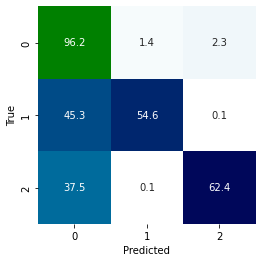

multiclass
cross_val results para el conjunto de test para # lags a futuro: 14


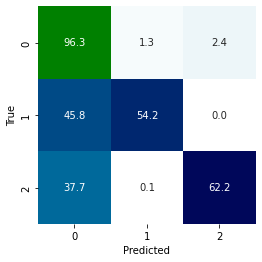

multiclass
cross_val results para el conjunto de test para # lags a futuro: 15


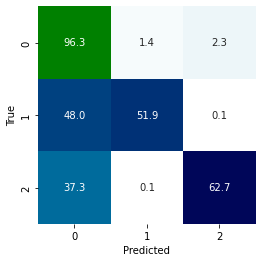

,Modelo,#lags,repeticiones,fit_time,score_time,test_accuracy,test_accuracy_desvest,train_accuracy,test_precision_macro,test_precision_macro_desvest,train_precision_macro,test_recall_macro,train_recall_macro
0,HistGradientBoostingClassifier(),1,15,2.176381,0.109441,0.938253,0.001942,0.952669,0.879081,0.004345,0.910289,0.866392,0.897133
1,HistGradientBoostingClassifier(),2,15,2.616471,0.124400,0.919979,0.002737,0.943861,0.853080,0.008519,0.904132,0.811142,0.863967
2,HistGradientBoostingClassifier(),3,15,3.323380,0.160305,0.913849,0.002323,0.945797,0.846904,0.006117,0.915133,0.786364,0.858064
3,HistGradientBoostingClassifier(),4,15,3.604096,0.174134,0.912834,0.002798,0.945630,0.850084,0.006531,0.919766,0.776348,0.853358
4,HistGradientBoostingClassifier(),5,15,4.164997,0.189559,0.912131,0.003061,0.950517,0.853263,0.008586,0.933686,0.766145,0.861171
5,HistGradientBoostingClassifier(),6,15,4.566788,0.215158,0.914847,0.002020,0.954149,0.862558,0.007254,0.941527,0.769205,0.867802
6,HistGradientBoostingClassifier(),7,15,4.483013,0.200731,0.910810,0.002907,0.950580,0.855711,0.006741,0.936200,0.757715,0.856815
7,HistGradientBoostingClassifier(),8,15,4.458345,0.204254,0.910657,0.002443,0.950790,0.854672,0.005567,0.938455,0.754842,0.855267
8,HistGradientBoostingClassifier(),9,15,4.585207,0.211368,0.911712,0.001809,0.952247,0.857488,0.006754,0.939995,0.760586,0.862456
9,HistGradientBoostingClassifier(),10,15,4.568783,0.218682,0.909710,0.002089,0.949692,0.854661,0.006254,0.937017,0.754100,0.853646


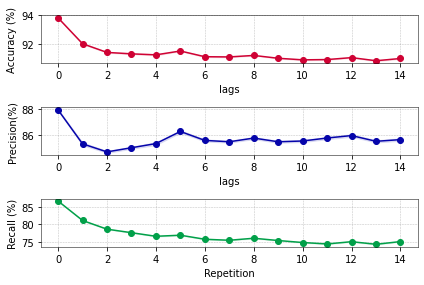

In [40]:
evaluar_adelante(clf4)

En general, observamos una pérdida en la capacidad predictiva del modelo a futuro: a medida que el horizonte de tiempo aumenta, es más difícil predecir las condiciones de arbitraje. Los resultados más sobresalientes se obtienen para la evaluación a un lag en donde observamos resultados similares a los observados para los modelos de rezagos en los precios.

### Evaluación a futuro para un clasificador por mayoría de votos

Evaluamos un clasificador por mayoría de votos. esta vez incluimos el  modelo base (Random Forest) en el análisis teniendo en cuenta que produjo resultados superiores en términos de las metricas de rendimiento para el primer lag.

In [41]:
#Definimos el max voting para los clasificadores tratados en el numeral anterior
mv_skln_fut=VotingClassifier(estimators=[('clf1', clf1), ('clf2', clf2), ('clf3', clf3), ('clf4', clf4)],voting='hard', weights=None)

multiclass
cross_val results para el conjunto de test para # lags a futuro: 1


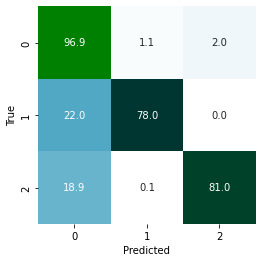

multiclass
cross_val results para el conjunto de test para # lags a futuro: 2


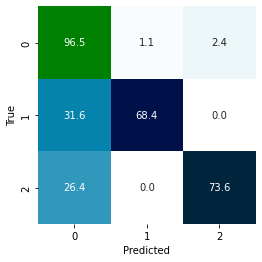

multiclass
cross_val results para el conjunto de test para # lags a futuro: 3


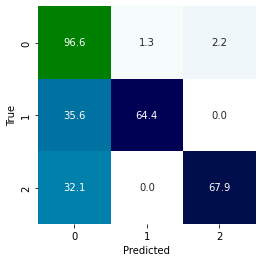

multiclass
cross_val results para el conjunto de test para # lags a futuro: 4


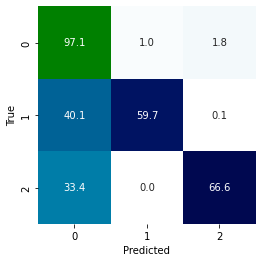

multiclass
cross_val results para el conjunto de test para # lags a futuro: 5


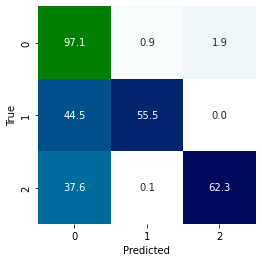

multiclass
cross_val results para el conjunto de test para # lags a futuro: 6


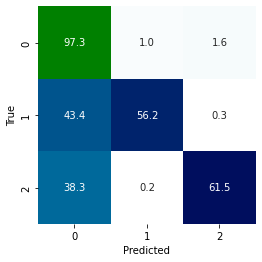

multiclass
cross_val results para el conjunto de test para # lags a futuro: 7


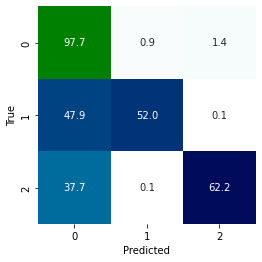

multiclass
cross_val results para el conjunto de test para # lags a futuro: 8


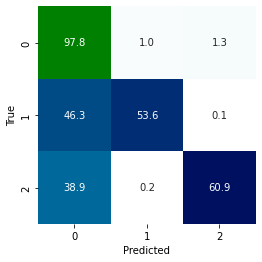

multiclass
cross_val results para el conjunto de test para # lags a futuro: 9


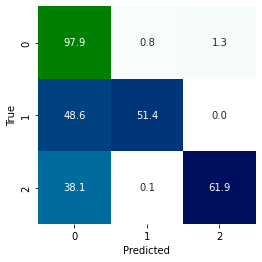

multiclass
cross_val results para el conjunto de test para # lags a futuro: 10


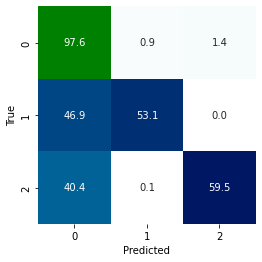

multiclass
cross_val results para el conjunto de test para # lags a futuro: 11


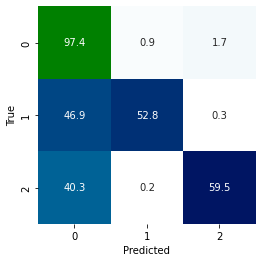

multiclass
cross_val results para el conjunto de test para # lags a futuro: 12


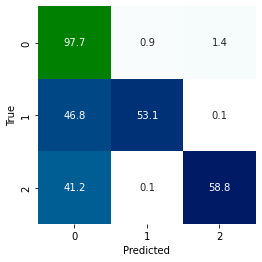

multiclass
cross_val results para el conjunto de test para # lags a futuro: 13


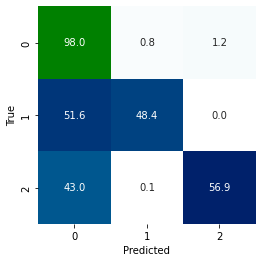

multiclass
cross_val results para el conjunto de test para # lags a futuro: 14


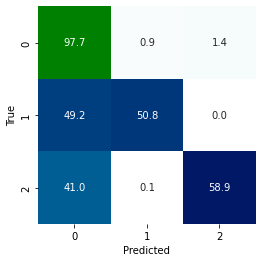

multiclass
cross_val results para el conjunto de test para # lags a futuro: 15


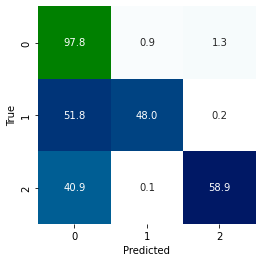

,Modelo,#lags,repeticiones,fit_time,score_time,test_accuracy,test_accuracy_desvest,train_accuracy,test_precision_macro,test_precision_macro_desvest,train_precision_macro,test_recall_macro,train_recall_macro
0,"VotingClassifier(estimators=[('clf1',\n ...",1,15,9.765016,0.432379,0.938417,0.001778,0.960125,0.886007,0.005227,0.940336,0.858339,0.897961
1,"VotingClassifier(estimators=[('clf1',\n ...",2,15,10.456273,0.475403,0.922785,0.002004,0.951243,0.866800,0.005444,0.933712,0.806047,0.863667
2,"VotingClassifier(estimators=[('clf1',\n ...",3,15,11.754764,0.526593,0.916747,0.002098,0.950775,0.868617,0.006125,0.944461,0.771566,0.851369
3,"VotingClassifier(estimators=[('clf1',\n ...",4,15,12.228930,0.544347,0.913503,0.002257,0.947419,0.872188,0.008256,0.949401,0.751479,0.833737
4,"VotingClassifier(estimators=[('clf1',\n ...",5,15,12.587872,0.551526,0.915527,0.001894,0.949987,0.878931,0.004182,0.955349,0.753714,0.837923
5,"VotingClassifier(estimators=[('clf1',\n ...",6,15,12.529891,0.554787,0.913163,0.002187,0.947345,0.884602,0.006770,0.958398,0.738903,0.825720
6,"VotingClassifier(estimators=[('clf1',\n ...",7,15,12.354927,0.545081,0.910929,0.002918,0.945346,0.883927,0.009988,0.958102,0.728885,0.819460
7,"VotingClassifier(estimators=[('clf1',\n ...",8,15,12.782012,0.562906,0.910288,0.002450,0.944972,0.883852,0.012650,0.958773,0.723145,0.815182
8,"VotingClassifier(estimators=[('clf1',\n ...",9,15,12.699568,0.559242,0.909914,0.002219,0.944416,0.884519,0.005663,0.959908,0.722545,0.812429
9,"VotingClassifier(estimators=[('clf1',\n ...",10,15,12.808613,0.567688,0.908928,0.001901,0.943192,0.886634,0.007699,0.959175,0.715074,0.807338


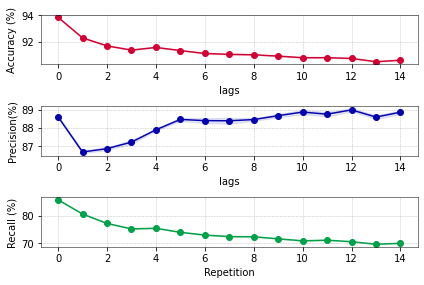

In [42]:
evaluar_adelante(mv_skln_fut)

Observamos que los resultados para un horizonte de tiempo a una observación son los mejores y ofrecen resultados similares al enfoque por rezagos. Sin embargo, los modelos por rezagos tienden a registrar métricas superiores de rendimiento. Para el análisis posterior abordamos este enfoque, que supone que una predicción por lags es ligeramente superior a una por horizonte de tiempo. Sin embargo, el hecho más relevante tiene que ver con el horizonte de predicción: en ambos casos concluimos que los resultados óptimos se obtienen al realizar las predicciones a un horizonte de tiempo de una observación (el siguiente minuto).

### Backtesting: Estado de pérdidas y ganancias para las predicciones

Para esta última parte del ejercicio realizamos el análisis de rendimiento financiero de la predicción a modo de backtesting: definimos uan función de evaluación fianciera y determinamos, con una base de prueba, cuáles fueron los resultados financieros en términos del estado de pérdidas y ganancias si se hubieran ejecutado las operaciones de trading (arbitraje) correspondientes.

In [43]:
import pytz
import time
from datetime import datetime, timezone
from datetime import timedelta

### Evaluación pérdidas y ganancias:

Definimos una función para evaluar, dado un modelo, un número de lags y un size de número de títulos a negociar, el estado de pérdidas y ganancias para las predicciones en caso de que para cada predicción de arbitraje, se haya enviado a cada uno de los mercados una orden simultánea de compra y una orden de venta cuando la predicción así lo indicaba.
Esta función depende de la definición de la función de arbitraje que adoptamos en la construcción de la base de datos original.

In [44]:
#Depende de las condiciones de arbitraje definidas
def evaluacion_financiera(modelo,lag,size):
   #Arbitraje directo
    
    spreads=[]
    utilidades=[]
    
    
    lags_lag=base_lags(base,lag)
    columnas_fecha=['Date', 'Hora_COL', 'Minuto', 'Hora_NY', 'Festivo_COL', 'Festivo_NYSE', 'Next_Day', 'Subasta','PFB_ABIERTO','CIB_ABIERTO']
    columnas_arb=['Arbitraje_BE_SL','Arbitraje_BL_SE','Arbitraje']
    cols_sobrantes=columnas_fecha+columnas_precio+columnas_arb
    X=lags_lag.drop(cols_sobrantes, axis=1)
    X_std=StandardScaler().fit_transform(X)
    y_BL_SE=lags_lag['Arbitraje_BL_SE']
    y_BE_SL=lags_lag['Arbitraje_BE_SL']
    y_target=lags_lag['Arbitraje']
    y_cat=[]
    for i in range(len(X)):
        if y_target.loc[i+lag]==1: 
            y_cat.append(1)
        elif y_target.loc[i+lag]==2:
            y_cat.append(2)
        else:
            y_cat.append(0)
    
    
    indices=np.arange(len(X))
    X_train, X_test, y_train, y_test, indx_train, indx_test = train_test_split(X_std, y_cat,indices, test_size=0.3, random_state=None, stratify=y_cat,shuffle=True)
    
    
    
    predictions = cross_val_predict(modelo, X_test,y_test,cv=StratifiedKFold(n_splits=3, shuffle=True))
    
    resultados=pd.DataFrame(columns=['Real','Predictions','Spread','Utilidad'], index=indx_test)
    resultados['Real']=y_target
    resultados['Predictions']=predictions
    resultados['Spread']=None
    resultados['Utilidad']=None
    print(resultados.iloc[1])
    
    for i in range(len(resultados.index)):
        indx=resultados.index[i]
        #si hay festivo en ambos mercados no hay spread ni utilidad
        if (base['Festivo_COL'].iloc[indx]==True) and (base['Festivo_NYSE'].iloc[indx]==True): 
            resultados['Spread'].iloc[i]=0
            resultados['Utilidad'].iloc[i]=0
        #si ambos mercados están cerrados no hay spread ni utlidades    
        elif (base['PFB_ABIERTO'].iloc[indx]==0) and (base['CIB_ABIERTO'].iloc[indx]==0) : 
            resultados['Spread'].iloc[i]=0
            resultados['Utilidad'].iloc[i]=0
        #si ambos mercados están abiertos en sesión de mercado abierto, no subasta:
        elif (base['PFB_ABIERTO'].iloc[indx]==1) and (base['CIB_ABIERTO'].iloc[indx]==1) and (base['Subasta'].iloc[indx]==0): 
            if resultados['Predictions'].iloc[i]==0: #si se predice no arbitraje, no hay spread ni utilidades
                resultados['Spread'].iloc[i]=0
                resultados['Utilidad'].iloc[i]=0
            if resultados['Predictions'].iloc[i]==1: #si se predice BE-SL, la utilidad es el spread de precios multiplicado por el size.
                resultados['Spread'].iloc[i]=base['Spread_BE_SL'].iloc[indx]
                resultados['Utilidad'].iloc[i]= base['Spread_BE_SL'].iloc[indx]*size
            if resultados['Predictions'].iloc[i]==2: #si se predice Bl-SE, la utilidad es el spread de precios multiplicado por el size.
                resultados['Spread'].iloc[i]=base['Spread_BL_SE'].iloc[indx]
                resultados['Utilidad'].iloc[i]= base['Spread_BL_SE'].iloc[indx]*size
        #En la subasta de cierre, el spread está dado por el precio de cierre de la subasta        
        elif (base['PFB_ABIERTO'].iloc[indx]==1) and (base['CIB_ABIERTO'].iloc[indx]==1) and (base['Subasta'].iloc[indx]==1):
            day=base['Date'].iloc[indx]
            hora=base['Hora_COL'].iloc[indx]
            hora_ny=base['Hora_NY'].iloc[indx]
            if hora==hora_ny: #en horario de invierno
                close_PFB=float(base[(base['Date']==day) & (base['Hora_COL']==16) & (base['Minuto']==30)]['PFB_close'])
                cib_eq_buy=(base['ASK_CIB'].iloc[indx]+0.008)*(base['USD_ASK'].iloc[indx]+0.5)/4
                cib_eq_sell=(base['BID_CIB'].iloc[indx]-0.008)*(base['USD_BID'].iloc[indx]-0.5)/4
                
            if hora!=hora_ny: #en horario de verano
                close_PFB=float(base[(base['Date']==day) & (base['Hora_COL']==15) & (base['Minuto']==30)]['PFB_close'])
                cib_eq_buy=(base['ASK_CIB'].iloc[indx]+0.008)*(base['USD_ASK'].iloc[indx]+0.5)/4
                cib_eq_sell=(base['BID_CIB'].iloc[indx]-0.008)*(base['USD_BID'].iloc[indx]-0.5)/4
            #Si no hay arbitraje, no hay spread ni utilidad
            if resultados['Predictions'].iloc[i]==0:
                resultados['Spread'].iloc[i]=0
                resultados['Utilidad'].iloc[i]=0
            #Si se predice BE-SL, se compara el precio de cierre de la subasta de PFB contra el precio actual de CIB
            if resultados['Predictions'].iloc[i]==1:
                resultados['Spread'].iloc[i]= close_PFB-cib_eq_buy #Spread
                resultados['Utilidad'].iloc[i]= (close_PFB-cib_eq_buy)*size 
            #Si se predice BL-SE, se compara el precio actual de CIB contra el precio de cierre de la subasta de PFB
            if resultados['Predictions'].iloc[i]==2:
                resultados['Spread'].iloc[i]= cib_eq_sell - close_PFB
                resultados['Utilidad'].iloc[i]= (cib_eq_sell-close_PFB)*size
        #Si Colombia está cerrado y NY abierto: se compara el precio de apertura de PFB al día siguiente contra el precio de CIB
        elif (base['PFB_ABIERTO'].iloc[indx]==0) and (base['CIB_ABIERTO'].iloc[indx]==1): 
            day=base['Date'].iloc[indx]
            time_index=np.where(base['Date'].unique()==day)[0][0]
            NextDay_Date = base['Date'].unique()[time_index+1]
            hora=base['Hora_COL'].iloc[indx]
            hora_ny=base['Hora_NY'].iloc[indx]
            if hora==hora_ny:
                open_PF=float(base[(base['Date']==NextDay_Date) & (base['Hora_COL']==9) & (base['Minuto']==30)]['PFB_close'])
                cib_eq_buy=(base['ASK_CIB'].iloc[indx]+0.008)*(base['USD_ASK'].iloc[indx]+0.5)/4
                cib_eq_sell=(base['BID_CIB'].iloc[indx]-0.008)*(base['USD_BID'].iloc[indx]-0.5)/4
                
            if hora!=hora_ny:
                open_PFB=float(base[(base['Date']==NextDay_Date) & (base['Hora_COL']==8) & (base['Minuto']==30)]['PFB_close'])
                cib_eq_buy=(base['ASK_CIB'].iloc[indx]+0.008)*(base['USD_ASK'].iloc[indx]+0.5)/4
                cib_eq_sell=(base['BID_CIB'].iloc[indx]-0.008)*(base['USD_BID'].iloc[indx]-0.5)/4
            if resultados['Predictions'].iloc[i]==0: #si no se predice arbitraje, no hay spread ni utilidad.
                resultados['Spread'].iloc[i]=0
                resultados['Utilidad'].iloc[i]=0
            if resultados['Predictions'].iloc[i]==1: #Si se predice BE-SL, se compara la apertura de PFB contra el precio actual de CIB
                resultados['Spread'].iloc[i]= open_PF-cib_eq_buy
                resultados['Utilidad'].iloc[i]= (open_PF-cib_eq_buy)*size
            if resultados['Predictions'].iloc[i]==2: #Se se predice BL-SE, se compara el precio actual de CIB contra la apertura de CIB
                resultados['Spread'].iloc[i]= cib_eq_sell - open_PFB
                resultados['Utilidad'].iloc[i]= (cib_eq_sell-open_PFB)*size
        #si NY está cerrado pero Colombia abierto y no es horario de subasta       
        elif (base['CIB_ABIERTO'].iloc[indx]==0) and (base['PFB_ABIERTO'].iloc[indx]==1) and (base['Subasta'].iloc[indx]==0): 
            day=base['Date'].iloc[indx]
            time_index=np.where(base['Date'].unique()==day)[0][0]
            NextDay_Date = base['Date'].unique()[time_index+1]
            hora=base['Hora_COL'].iloc[indx]
            hora_ny=base['Hora_NY'].iloc[indx]
            if hora==hora_ny: # En horario de invierno
                open_CIB=float(base[(base['Date']==NextDay_Date) & (base['Hora_COL']==9) & (base['Minuto']==30)]['CIB_close'])
                open_USD=float(base[(base['Date']==NextDay_Date) & (base['Hora_COL']==9) & (base['Minuto']==30)]['COP_close'])
                open_cib_eq_buy=(open_CIB+0.008)*(open_USD+0.5)/4
                open_cib_eq_sell=(open_CIB-0.008)*(open_USD-0.5)/4
                pfb_eq_buy=base['ASK_PFB'].iloc[indx]
                pfb_eq_sell=base['BID_PFB'].iloc[indx]
                
            if hora!=hora_ny: #En horario de verano
                open_CIB=float(base[(base['Date']==NextDay_Date) & (base['Hora_COL']==8) & (base['Minuto']==30)]['CIB_close'])
                open_USD=float(base[(base['Date']==NextDay_Date) & (base['Hora_COL']==8) & (base['Minuto']==30)]['COP_close'])
                open_cib_eq_buy=(open_CIB+0.008)*(open_USD+0.5)/4
                open_cib_eq_sell=(open_CIB-0.008)*(open_USD-0.5)/4
                pfb_eq_buy=base['ASK_PFB'].iloc[indx]
                pfb_eq_sell=base['BID_PFB'].iloc[indx]
            if resultados['Predictions'].iloc[i]==0:
                resultados['Spread'].iloc[i]=0
                resultados['Utilidad'].iloc[i]=0
            if resultados['Predictions'].iloc[i]==1:
                resultados['Spread'].iloc[i]= pfb_eq_sell-open_cib_eq_buy
                resultados['Utilidad'].iloc[i]= (pfb_eq_sell-open_cib_eq_buy)*size
            if resultados['Predictions'].iloc[i]==2:
                resultados['Spread'].iloc[i]= open_cib_eq_sell- open_PFB
                resultados['Utilidad'].iloc[i]= (open_cib_eq_sell-pfb_eq_buy)*size
        #si NY está cerrado pero Colombia abierto (durante la subasta)
        elif (base['CIB_ABIERTO'].iloc[indx]==0) and (base['PFB_ABIERTO'].iloc[indx]==1) and (base['Subasta'].iloc[indx]==1): 
            day=base['Date'].iloc[indx]
            time_index=np.where(base['Date'].unique()==day)[0][0]
            NextDay_Date = base['Date'].unique()[time_index+1]
            hora=base['Hora_COL'].iloc[indx]
            hora_ny=base['Hora_NY'].iloc[indx]
            if hora==hora_ny: # En horario de invierno
                open_CIB=float(base[(base['Date']==NextDay_Date) & (base['Hora_COL']==9) & (base['Minuto']==30)]['CIB_close'])
                open_USD=float(base[(base['Date']==NextDay_Date) & (base['Hora_COL']==9) & (base['Minuto']==30)]['COP_close'])
                open_PFB=float(base[(base['Date']==NextDay_Date) & (base['Hora_COL']==9) & (base['Minuto']==30)]['PFB_close'])
                open_cib_eq_buy=(open_CIB+0.008)*(open_USD+0.5)/4
                open_cib_eq_sell=(open_CIB-0.008)*(open_USD-0.5)/4
                pfb_eq_buy=open_PFB
                pfb_eq_sell=open_PFB
                
            if hora!=hora_ny: #En horario de verano
                open_CIB=float(base[(base['Date']==NextDay_Date) & (base['Hora_COL']==8) & (base['Minuto']==30)]['CIB_close'])
                open_USD=float(base[(base['Date']==NextDay_Date) & (base['Hora_COL']==8) & (base['Minuto']==30)]['COP_close'])
                open_PFB=float(base[(base['Date']==NextDay_Date) & (base['Hora_COL']==8) & (base['Minuto']==30)]['PFB_close'])
                open_cib_eq_buy=(open_CIB+0.008)*(open_USD+0.5)/4
                open_cib_eq_sell=(open_CIB-0.008)*(open_USD-0.5)/4
                pfb_eq_buy=open_PFB
                pfb_eq_sell=open_PFB
            if resultados['Predictions'].iloc[i]==0:
                resultados['Spread'].iloc[i]=0
                resultados['Utilidad'].iloc[i]=0
            if resultados['Predictions'].iloc[i]==1:
                resultados['Spread'].iloc[i]= pfb_eq_sell-open_cib_eq_buy
                resultados['Utilidad'].iloc[i]= (pfb_eq_sell-open_cib_eq_buy)*size
            if resultados['Predictions'].iloc[i]==2:
                resultados['Spread'].iloc[i]= open_cib_eq_sell- open_PFB
                resultados['Utilidad'].iloc[i]= (open_cib_eq_sell-pfb_eq_buy)*size
        
              
          
    return resultados
    
    

In [45]:
#Evaluamos los resultados para 12 lags
resultados=evaluacion_financiera(mv_skln,12,10000)

Real              0
Predictions       0
Spread         None
Utilidad       None
Name: 47649, dtype: object


C:\Users\fract\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [46]:
resultados

,Real,Predictions,Spread,Utilidad
35504,0,0,0,0
47649,0,0,0,0
10451,0,0,0,0
8782,0,0,0,0
26067,2,0,0,0
...,...,...,...,...
9613,0,0,0,0
41324,1,0,0,0
15453,0,0,0,0
23956,0,0,0,0


In [47]:
#extraemos la base de características temporales para concatenar con los resultados
index=resultados.index
base_test=base.loc[index][columnas_fecha]

In [48]:
#concatenamos los resultados de la predicción con las características temporales.
result=pd.concat([base_test,resultados], join='outer', axis=1)

In [49]:
result

,Date,Hora_COL,Minuto,Hora_NY,Festivo_COL,Festivo_NYSE,Next_Day,Subasta,PFB_ABIERTO,CIB_ABIERTO,Real,Predictions,Spread,Utilidad
35504,2022-04-04,16,38,17,False,False,1,0,0,0,0,0,0,0
47649,2022-05-05,12,3,13,False,False,0,0,1,1,0,0,0,0
10451,2022-01-28,13,5,13,False,False,1,0,1,1,0,0,0,0
8782,2022-01-25,12,16,12,False,False,0,0,1,1,0,0,0,0
26067,2022-03-10,12,21,12,False,False,0,0,1,1,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9613,2022-01-27,8,7,8,False,False,0,0,0,0,0,0,0,0
41324,2022-04-19,14,38,15,False,False,1,0,1,1,1,0,0,0
15453,2022-02-10,15,27,15,False,False,1,0,1,1,0,0,0,0
23956,2022-03-04,13,10,13,False,False,1,0,1,1,0,0,0,0


In [50]:
#Creamos el archivo de excel con los resultados de la evaluación
result.to_excel("resultados_best.xlsx")

En el siguente notebook, realizaremos un análisis de los resultados obtenidos con base en este archivo y trataremos de ajustar las predicciones a la realidad operativa de los mercados con el fin de establecer una evaluación financiera adecuada de los modelos.